In [26]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import f_oneway
from matplotlib import pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
from scipy.fft import fft2, fftshift, ifft2
import ast


from sklearn.model_selection import train_test_split
from functools import partial
from multiprocessing import Pool
from PIL import Image

In [27]:
def resize_with_aspect_ratio(image, target_size=(512, 512)):
    """
    Resizes an image to fit within a target size while maintaining the aspect ratio.
    Adds padding to center the image on a black background.

    Parameters:
        image (numpy.ndarray): Input image to resize.
        target_size (tuple): Target dimensions (height, width).

    Returns:
        numpy.ndarray: Padded image with the target dimensions.
    """
    # Original and target dimensions
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    # Calculate scale factor and new dimensions
    scale = min(target_w / w, target_h / h)
    new_dims = (int(w * scale), int(h * scale))
    
    # Resize image and create padded canvas
    resized_image = cv2.resize(image, new_dims, interpolation=cv2.INTER_AREA)
    padded_image = np.full((target_h, target_w, 3), 0, dtype=np.uint8)
    
    # Calculate offsets for centering
    y_offset = (target_h - new_dims[1]) // 2
    x_offset = (target_w - new_dims[0]) // 2
    
    # Place resized image on the canvas
    padded_image[y_offset:y_offset + new_dims[1], x_offset:x_offset + new_dims[0]] = resized_image
    return padded_image

In [28]:
def crop_retina_image(image_bgr, output_size=(512, 512)):
    """
    Crops a retina image to the largest contour's bounding rectangle and resizes it.

    Parameters:
        image_bgr (numpy.ndarray): Input image in BGR format.
        output_size (tuple): Target dimensions (height, width).

    Returns:
        numpy.ndarray: Cropped and resized image in BGR format.
    """
    # Validate the input image
    if image_bgr is None or image_bgr.size == 0:
        raise ValueError("Invalid or empty input image.")

    # Convert to grayscale and threshold to create a binary mask
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Detect contours and validate their presence
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the input image.")

    # Crop the largest contour's bounding rectangle
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    cropped = image_bgr[y:y+h, x:x+w]

    # Resize cropped image and return
    return resize_with_aspect_ratio(cropped, target_size=output_size)

In [29]:
def detect_exposure(image_bgr, over_threshold=195, under_threshold=15, exposure_ratio=0.6):
    """
    Detects whether an image is overexposed or underexposed based on pixel intensity thresholds.

    Parameters:
        image_bgr (numpy.ndarray): Input image in BGR format.
        over_threshold (int): Pixel intensity above this value is considered overexposed (default: 200).
        under_threshold (int): Pixel intensity below this value is considered underexposed (default: 20).
        exposure_ratio (float): Maximum allowed ratio of over/underexposed pixels (default: 0.7).

    Returns:
        tuple: 
            - is_not_overexposed (bool): Whether the image is not overexposed.
            - is_not_underexposed (bool): Whether the image is not underexposed.
            - over_ratio (float): Ratio of overexposed pixels.
            - under_ratio (float): Ratio of underexposed pixels.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    # Calculate total pixels and counts of overexposed/underexposed pixels
    total_pixels = gray.size
    overexposed_pixels = np.sum(gray >= over_threshold)
    underexposed_pixels = np.sum(gray <= under_threshold)

    # Compute the ratios of overexposed and underexposed pixels
    over_ratio = overexposed_pixels / total_pixels
    under_ratio = underexposed_pixels / total_pixels

    # Check if the image is within acceptable exposure limits
    is_not_overexposed = over_ratio <= exposure_ratio
    is_not_underexposed = under_ratio <= exposure_ratio

    # Return the results
    return is_not_overexposed, is_not_underexposed, over_ratio, under_ratio

In [30]:
def create_output_folders(base_folder):
    """
    Creates necessary output folders for image categorization.

    Parameters:
        base_folder (str): Path to the base output folder.

    Returns:
        dict: Dictionary with keys ('Underexposed', 'Overexposed', 'Well-exposed') and paths to the corresponding folders.
    """
    # Ensure the base folder exists
    os.makedirs(base_folder, exist_ok=True)

    # Define and create subfolders
    folders = {"Underexposed": os.path.join(base_folder, "Underexposed"),
               "Overexposed": os.path.join(base_folder, "Overexposed"),
               "Well-exposed": os.path.join(base_folder, "Well-exposed")}
    for path in folders.values():
        os.makedirs(path, exist_ok=True)

    # Return the dictionary of folder paths
    return folders

In [31]:
def categorize_and_save_image(image_bgr, image_name, exposure_results, output_folders):
    """
    Categorizes an image based on exposure results and saves it in the appropriate folder.

    Parameters:
        image_bgr (numpy.ndarray): Image in BGR format to be saved.
        image_name (str): Name for the saved image file (without extension).
        exposure_results (tuple): Exposure results as (is_not_overexposed, is_not_underexposed, over_ratio, under_ratio).
        output_folders (dict): Dictionary of output folder paths with keys ('Underexposed', 'Overexposed', 'Well-exposed').

    Returns:
        tuple: 
            - category (str): Exposure category ('Well-exposed', 'Overexposed', 'Underexposed', or 'Error').
            - output_path (str or None): Path where the image was saved, or None if an error occurred.
            - over_ratio (float): Ratio of overexposed pixels.
            - under_ratio (float): Ratio of underexposed pixels.
    """
    # Unpack exposure results
    is_not_overexposed, is_not_underexposed, over_ratio, under_ratio = exposure_results

    # Determine the category based on exposure results
    if is_not_overexposed and is_not_underexposed:
        category = "Well-exposed"
    elif not is_not_overexposed:
        category = "Overexposed"
    elif not is_not_underexposed:
        category = "Underexposed"
    else:
        return "Error", None, over_ratio, under_ratio

    # Construct the output path for the image
    output_path = os.path.join(output_folders[category], f"{image_name}.jpeg")

    # Save the image in BGR format directly
    cv2.imwrite(output_path, image_bgr)
    
    # Return the category, path, and exposure ratios
    return category, output_path, over_ratio, under_ratio

In [33]:
def process_images(image_folder, csv_path, output_folder, output_size=(512, 512), max_workers=12):
    """
    A parallelized pipeline for processing images with proper histogram handling.
    """
    # Step 1: Create categorized output folders
    output_folders = create_output_folders(output_folder)

    # Step 2: Read the CSV file into a DataFrame
    labels_df = pd.read_csv(csv_path)

    # Initialize containers for results and histograms
    all_results = []
    all_hists = []

    # Step 3: Process images in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for _, row in labels_df.iterrows():
            future = executor.submit(process_single_row, row, image_folder, output_folders, output_size)
            futures.append(future)

        # Process results as futures complete
        for f in tqdm(as_completed(futures), total=len(futures), desc="Processing in parallel"):
            res = f.result()
            all_results.append(res)

            # If the result contains a valid histogram, parse and store it
            if "histogram" in res and res["histogram"] is not None:
                try:
                    # Parse the histogram string back into a list using ast
                    hist_list = ast.literal_eval(res["histogram"])
                    all_hists.append(hist_list)
                except (ValueError, SyntaxError) as e:
                    print(f"Error parsing histogram for {res['image']}: {e}")

    # Step 4: Build a DataFrame from the results
    results_df = pd.DataFrame(all_results)

    # Step 5: Aggregate histograms across all processed images
    if len(all_hists) > 0:
        all_hists = np.array(all_hists, dtype=float)  # Now this should work as we're converting from lists
        aggregated_hist = np.mean(all_hists, axis=0)
        std_hist = np.std(all_hists, axis=0)
    else:
        aggregated_hist = None
        std_hist = None

    return results_df, aggregated_hist, std_hist

In [34]:
def process_single_image(row, results, per_image_histograms, output_size):
    """
    Processes a single image: cropping, resizing, and histogram computation.

    Parameters:
        row (pd.Series): Row of the DataFrame containing image metadata.
        results (list): List to store processing results.
        per_image_histograms (list): List to store individual image histograms.
        output_size (tuple): Target size for image resizing.

    Returns:
        None
    """
    image_name, label, image_path = row["image"], row["level"], row["image_path"]

    if not os.path.isfile(image_path):
        results.append({"image": image_name, "label": label, "category": "File not found"})
        return

    try:
        # Load and process the image
        bgr_image = cv2.imread(image_path)
        cropped_bgr = crop_retina_image(bgr_image, output_size)

        if cropped_bgr is None or cropped_bgr.size == 0:
            raise ValueError(f"Invalid cropped image for {image_name}")

        # Convert to grayscale and compute histogram
        gray_image = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2GRAY)
        hist, _ = np.histogram(gray_image.ravel(), bins=256, range=(0, 256), density=False)

        per_image_histograms.append(hist)

        # Store intermediate results
        results.append({"image": image_name,
                        "label": label,
                        "cropped_image": cropped_bgr,
                        "gray_image": gray_image})

    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        results.append({"image": image_name, "label": label, "category": "Error"})

In [35]:
def categorize_images(results, output_folders):
    """
    Categorizes images based on exposure and saves them in respective folders.

    Parameters:
        results (list): List of results with cropped images.
        output_folders (dict): Dictionary of output folder paths.

    Returns:
        list: Final results with categorization and exposure ratios.
    """
    final_results = []

    for result in tqdm(results, desc="Categorizing Images"):
        if "cropped_image" not in result:
            final_results.append(result)
            continue

        cropped_bgr = result.pop("cropped_image")

        # Detect exposure and categorize
        exposure_results = detect_exposure(cropped_bgr)
        category, _, over_ratio, under_ratio = categorize_and_save_image(
            cropped_bgr,
            result["image"],
            exposure_results,
            output_folders)

        # Update result with categorization details
        result.update({"category": category,
                       "over_ratio": over_ratio,
                       "under_ratio": under_ratio})
        final_results.append(result)

    return final_results

In [36]:
def generate_summary_table(results_df):
    """
    Generates a summary table of counts based on category and label, including totals.

    Parameters:
        results_df (pandas.DataFrame): DataFrame containing at least 'category' and 'label' columns.

    Returns:
        pandas.DataFrame: Summary table with categories as rows, labels as columns, and counts as values,
                          including a "Total" column and a "Total" row.
    """
    # Group by 'category' and 'label', count occurrences, and reshape into a table
    summary_table = results_df.groupby(["category", "label"]).size().unstack(fill_value=0)

    # Add a "Total" column by summing across rows
    summary_table["Total"] = summary_table.sum(axis=1)

    # Add a "Total" row by summing across columns
    summary_table.loc["Total"] = summary_table.sum(axis=0)

    return summary_table

In [37]:
def plot_image_exposure_distributions(results_df, threshold=0.6):
    """
    Plots histograms for the distribution of underexposure and overexposure ratios.

    Parameters:
        results_df (pandas.DataFrame): DataFrame containing 'under_ratio' and 'over_ratio' columns.
        threshold (float): Threshold for distinguishing well-exposed images (default: 0.7).

    Returns:
        None
    """

    def plot_exposure(ax, data, color, title, label):
        """
        Internal helper to plot a single exposure distribution histogram.

        Parameters:
            ax (matplotlib.axes.Axes): Axis to plot on.
            data (pandas.Series): Exposure ratio data (e.g., 'under_ratio' or 'over_ratio').
            color (str): Color for the histogram and regions.
            title (str): Title for the subplot.
            label (str): Label for the histogram values.
        """
        # Plot histogram
        ax.hist(data, bins=128, alpha=0.7, color=color, label=f"{label} Values", log=True)
        
        # Plot threshold line
        ax.axvline(x=threshold, color="green", linestyle="--", label="Well-Exposed Threshold")
        
        # Add shaded regions
        ax.fill_betweenx([1, ax.get_ylim()[1]], 0, threshold, color="green", alpha=0.2, label="Well-Exposed Region")
        ax.fill_betweenx([1, ax.get_ylim()[1]], threshold, 1, color=color, alpha=0.2, label=f"{label} Region")
    
        # Add titles and labels
        ax.set_title(title, fontsize=16)
        ax.set_xlabel(f"{label} Ratio", fontsize=14)
        ax.set_ylabel("Number of Images (Log Scale)", fontsize=14)

        # Add grid and set limits
        ax.grid(alpha=0.5)
        ax.set_xlim(left=0)
        # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y)}"))
        ax.legend(fontsize=12)
        

    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot underexposure and overexposure histograms
    plot_exposure(axes[0], results_df["under_ratio"], "blue", "Underexposure Distribution", "Underexposure")
    plot_exposure(axes[1], results_df["over_ratio"], "red", "Overexposure Distribution", "Overexposure")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [38]:
def plot_histogram_statistics(aggregated_histogram, std_histogram, name):
    """
    Plots the aggregated pixel intensity histogram with statistical markers (mean, median, mode),
    the standard deviation range, and includes an additional plot in symmetric log scale with symmetric limits.

    Parameters:
        aggregated_histogram (np.ndarray): The aggregated histogram of pixel intensities (length 256).
        std_histogram (np.ndarray): The standard deviation of the histogram values (length 256).
    
    Returns:
        None
    """
    def plot_histogram(intensities, histogram, std, mean_val, median_val, mode_val, log_scale=False, symmetric_limit=None):
        """
        Internal function to handle plotting logic.

        Parameters:
            intensities (np.ndarray): Pixel intensity values (0-255).
            histogram (np.ndarray): Histogram values for the intensities.
            std (np.ndarray): Standard deviation for the histogram values.
            mean_val (float): Mean pixel intensity value.
            median_val (float): Median pixel intensity value.
            mode_val (float): Mode pixel intensity value.
            log_scale (bool): Whether to use a log or symmetric log scale for the y-axis.
            symmetric_limit (float): Maximum value for symmetric y-axis limits (used in symlog scale).

        Returns:
            None
        """
        plt.figure(figsize=(12, 6))
        plt.bar(intensities, histogram, color="gray", alpha=0.7, label="Mean Histogram")
        plt.fill_between(intensities,
                         histogram - std,  # Lower bound
                         histogram + std,  # Upper bound
                         color="blue", alpha=0.3, label="Std Dev Range")

        # Add vertical lines for statistics
        plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {mean_val:.2f}")
        plt.axvline(median_val, color="green", linestyle="--", linewidth=1.5, label=f"Median: {median_val:.2f}")
        plt.axvline(mode_val, color="orange", linestyle="--", linewidth=1.5, label=f"Mode: {mode_val:.0f}")

        plt.title("Aggregated Pixel Intensity Histogram" + (" (Log Scale)" if log_scale else "") + " - " + name, fontsize=16)
        plt.xlabel("Pixel Intensity", fontsize=14)
        plt.ylabel("Log(Frequency)" if log_scale else "Frequency", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.4)

        # Set x-ticks at every 16
        plt.xticks(ticks=np.arange(0, 256 + 16, 16))  # Add ticks from 0 to 256 with a step of 16

        # Set y-axis to log scale if required
        if log_scale:
            plt.yscale("symlog", linthresh=1)  # Symmetric log scale with a linear threshold at ±1
            plt.ylim(-symmetric_limit, symmetric_limit)  # Ensure symmetric y-axis limits

        plt.show()

    # Define the range of pixel intensities (0 to 255)
    intensities = np.arange(256)

    # Calculate statistical values
    mean_val = np.sum(aggregated_histogram * intensities) / np.sum(aggregated_histogram)
    cdf = np.cumsum(aggregated_histogram) / np.sum(aggregated_histogram)
    median_val = np.interp(0.5, cdf, intensities)
    mode_val = intensities[np.argmax(aggregated_histogram)]

    # Plot the regular histogram
    plot_histogram(intensities, aggregated_histogram, std_histogram, mean_val, median_val, mode_val, log_scale=False)

    # Calculate the maximum magnitude of the histogram for symmetric log-scale limits
    max_val = np.max(np.abs(aggregated_histogram + std_histogram))
    symmetric_limit = 10 ** np.ceil(np.log10(max_val))  # Round up to the nearest power of 10

    # Plot the log-scale histogram with symmetric limits
    plot_histogram(intensities, aggregated_histogram, std_histogram, mean_val, median_val, mode_val, log_scale=True, symmetric_limit=symmetric_limit)

In [39]:
def display_exposure_subplots(results_df, output_folder, num_images=5):
    """
    Displays a grid of images categorized by exposure levels (Underexposed, Overexposed, Well-exposed).

    Parameters:
        results_df (pandas.DataFrame): DataFrame containing image data with a 'category' and 'image' column.
        image_folder (str): Path to the folder containing categorized images.
        num_images (int): Number of images to display per category (default: 5).

    Returns:
        None
    """
    categories = ["Underexposed", "Overexposed", "Well-exposed"]
    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 9))
    fig.suptitle("Exposure Categories", fontsize=16)

    for i, category in enumerate(categories):
        # Get up to 'num_images' image names for the current category
        category_images = results_df[results_df["category"] == category]["image"].head(num_images)

        for j in range(num_images):
            ax = axes[i, j] if len(categories) > 1 else axes[j] 
            if j >= len(category_images):  # If there are no more images to display
                ax.axis("off")
                continue

            image_name = category_images.iloc[j]
            image_path = os.path.join(output_folder, category, f"{image_name}.jpeg")

            if os.path.isfile(image_path):
                # Load and display the image
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    ax.imshow(image)
                    ax.axis("off")
                    ax.set_title(image_name, fontsize=10)  # Add image name above the image
                else:
                    ax.axis("off")
            else:
                ax.axis("off")

        # Add row labels using a simple ylabel
        axes[i, 0].set_ylabel(category, fontsize=12, fontweight='bold', rotation=0, ha='right', va='center')

    # Adjust layout to make room for labels
    plt.subplots_adjust(left=0.15)
    plt.tight_layout(rect=[0.15, 0, 1, 0.95])
    plt.show()

In [41]:
def process_single_row(row, image_folder, output_folders, output_size):
    """
    Modified version to save histogram as a string representation of a list
    """
    image_name = row["image"]
    label = row["level"]
    image_path = os.path.join(image_folder, f"{image_name}.jpeg")

    result = {
        "image": image_name,
        "label": label,
        "category": None,
        "over_ratio": None,
        "under_ratio": None
    }

    if not os.path.isfile(image_path):
        result["category"] = "File not found"
        return result

    try:
        bgr_image = cv2.imread(image_path)
        cropped_bgr = crop_retina_image(bgr_image, output_size)
        gray_image = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2GRAY)
        
        # Compute histogram and convert to list before storing
        hist, _ = np.histogram(gray_image.ravel(), bins=256, range=(0, 256), density=False)
        hist_list = hist.tolist()  # Convert numpy array to list
        
        exposure_results = detect_exposure(cropped_bgr)
        category, _, over_ratio, under_ratio = categorize_and_save_image(
            cropped_bgr, image_name, exposure_results, output_folders)

        result["category"] = category
        result["over_ratio"] = over_ratio
        result["under_ratio"] = under_ratio
        result["histogram"] = str(hist_list)  # Store as string representation of list

    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        result["category"] = "Error"

    return result

In [42]:
def process_and_visualize_images(image_folder, output_folder, csv_path, preprocessing_done=False):
    """
    Processes and visualizes images based on the preprocessing flag and output folder existence.

    Parameters:
        preprocessing_done (bool): If True, skips the image processing step and uses existing results.
        image_folder (str): Path to the folder containing the input images.
        output_folder (str): Path to the folder where processed images are stored.
        csv_path (str): Path to the CSV file containing image labels.

    Returns:
        None
    """
    # Ensure the output folder exists
    if os.path.exists(output_folder):
        print(f"Output folder '{output_folder}' exists. Skipping processing...")
        preprocessing_done = True

    # Initialize variables for results and histograms
    results_df = None
    aggregated_histogram = None
    std_histogram = None

    # Define paths for saving results
    results_csv_path = os.path.join(output_folder, "exposure_results_with_labels.csv")
    summary_csv_path = os.path.join(output_folder, "exposure_summary_table.csv")
    aggregated_histogram_path = os.path.join(output_folder, "aggregated_histogram.npy")
    std_histogram_path = os.path.join(output_folder, "std_histogram.npy")

    if not preprocessing_done:
        print("Preprocessing not done. Running image processing pipeline...")
        # Run the processing pipeline
        results_df, aggregated_histogram, std_histogram = process_images(image_folder, csv_path, output_folder)

        # Save the results and histograms
        results_df.to_csv(results_csv_path, index=False)
        print(f"Results saved to '{results_csv_path}'.")

        summary_table = generate_summary_table(results_df)
        print("\nExposure Summary:")
        print(summary_table)
        summary_table.to_csv(summary_csv_path)
        print(f"Summary table saved to '{summary_csv_path}'.")

        if aggregated_histogram is not None and std_histogram is not None:
            np.save(aggregated_histogram_path, aggregated_histogram)
            np.save(std_histogram_path, std_histogram)
            print(f"Histogram data saved to '{aggregated_histogram_path}' and '{std_histogram_path}'.")
    
    else:
        print("Preprocessing is already done. Loading existing results...")
        if os.path.exists(results_csv_path):
            results_df = pd.read_csv(results_csv_path)
        else:
            raise FileNotFoundError(f"Expected results CSV not found at '{results_csv_path}'.")

        if os.path.exists(summary_csv_path):
            summary_table = pd.read_csv(summary_csv_path)
        else:
            raise FileNotFoundError(f"Expected summary CSV not found at '{summary_csv_path}'.")

        # Load histograms if available
        if os.path.exists(aggregated_histogram_path) and os.path.exists(std_histogram_path):
            aggregated_histogram = np.load(aggregated_histogram_path)
            std_histogram = np.load(std_histogram_path)
        else:
            print("Histogram data not found. Skipping histogram-related visualizations.")

    # Visualizations
    if aggregated_histogram is not None and std_histogram is not None:
        plot_histogram_statistics(aggregated_histogram, std_histogram, "Full Database")

    if results_df is not None:
        display_exposure_subplots(results_df, output_folder)
        plot_image_exposure_distributions(results_df)

    process_histogram_statistics(results_df)

In [45]:
def process_histogram_statistics(df):
    """
    Modified version to properly parse string histograms using ast
    """
    def parse_histogram(hist_string):
        try:
            # Use ast.literal_eval to safely evaluate the string representation
            hist_list = ast.literal_eval(hist_string)
            return np.array(hist_list)
        except (ValueError, SyntaxError) as e:
            print(f"Error parsing histogram: {e}")
            return None

    # Convert the 'histogram' column from strings to numpy arrays
    df['histogram'] = df['histogram'].apply(parse_histogram)
    
    # Remove rows where histogram parsing failed
    df = df.dropna(subset=['histogram'])
    
    # Group by category
    grouped = df.groupby('category')

    for category, group in grouped:
        # Stack histograms for the category
        histograms = np.stack(group['histogram'].to_numpy())

        # Calculate aggregated histogram (mean) and standard deviation
        aggregated_histogram = np.mean(histograms, axis=0)
        std_histogram = np.std(histograms, axis=0)

        # Call the plotting function
        plot_histogram_statistics(aggregated_histogram, std_histogram, category)

Preprocessing not done. Running image processing pipeline...


Processing in parallel: 100%|██████████| 35126/35126 [15:25<00:00, 37.94it/s]


Results saved to 'Data/Preprocessed\exposure_results_with_labels.csv'.

Exposure Summary:
label             0     1     2    3    4  Total
category                                        
Overexposed      50     3     2    1    0     56
Underexposed     67     8    29    5    6    115
Well-exposed  25693  2432  5261  867  702  34955
Total         25810  2443  5292  873  708  35126
Summary table saved to 'Data/Preprocessed\exposure_summary_table.csv'.
Histogram data saved to 'Data/Preprocessed\aggregated_histogram.npy' and 'Data/Preprocessed\std_histogram.npy'.


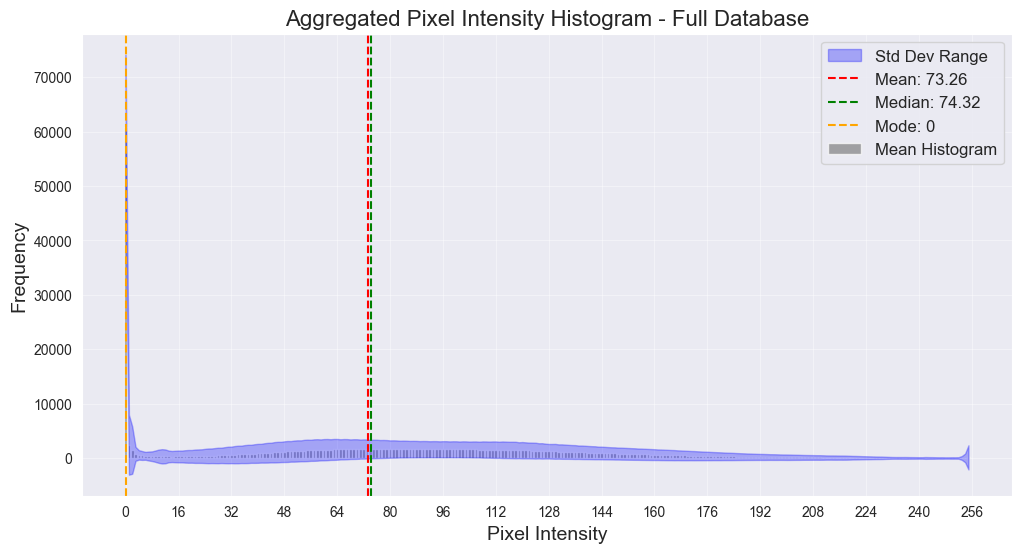

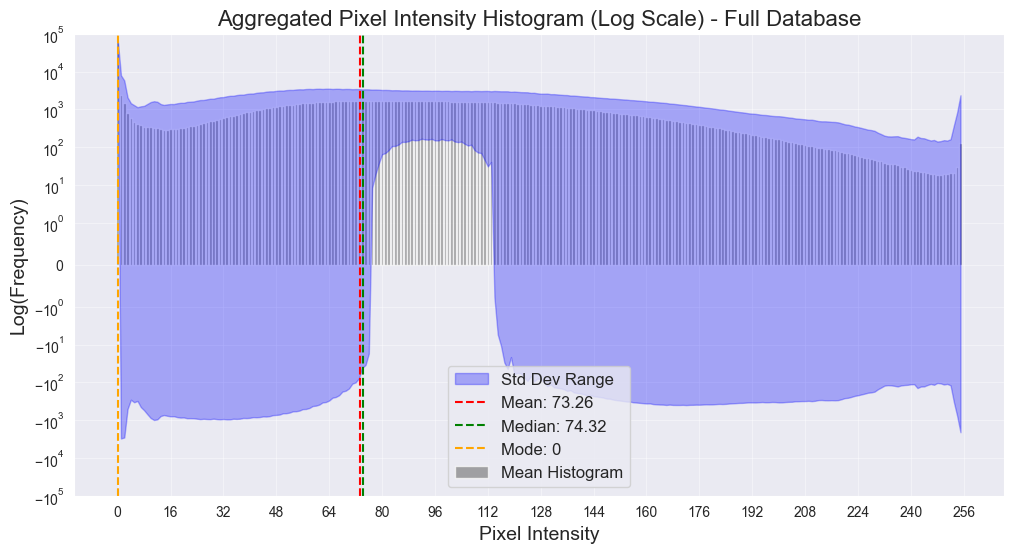

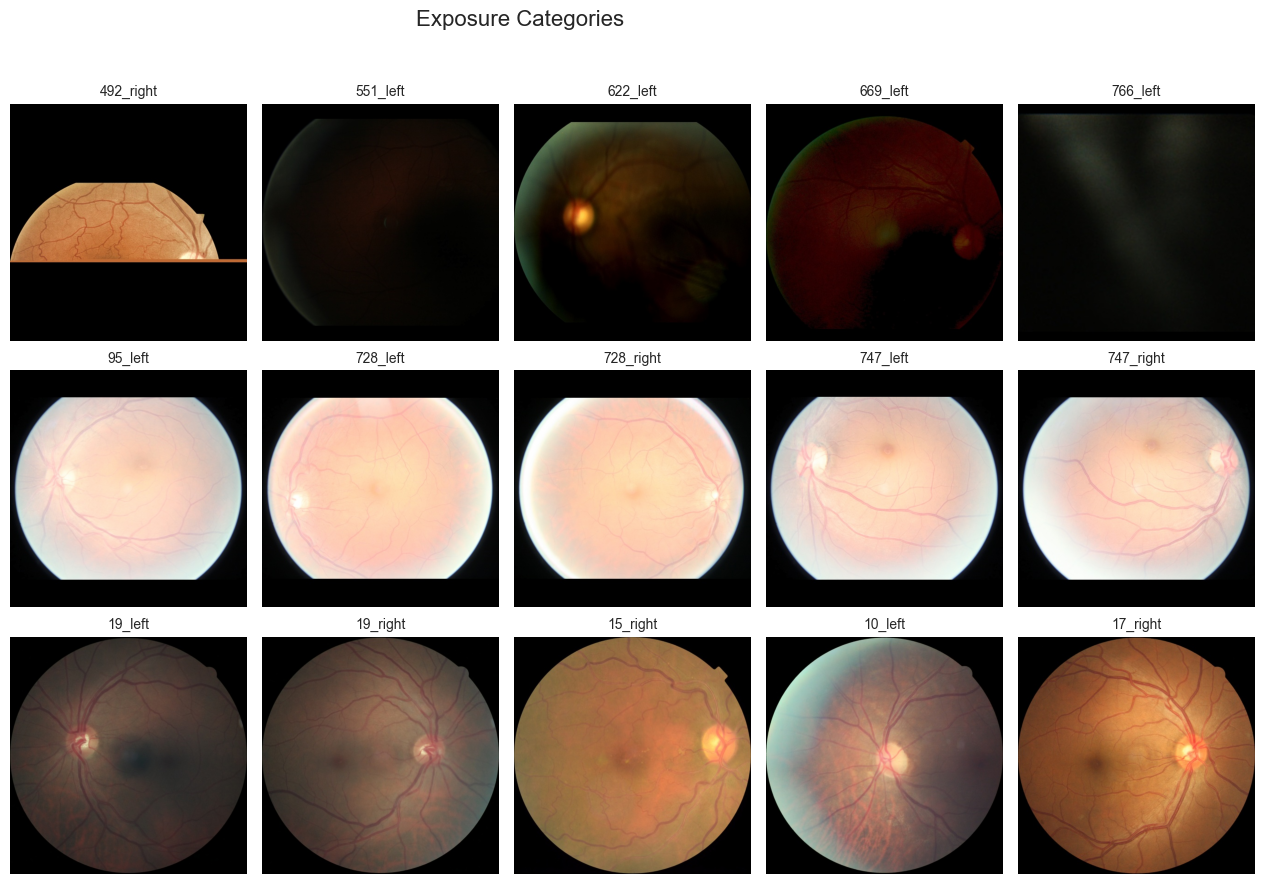

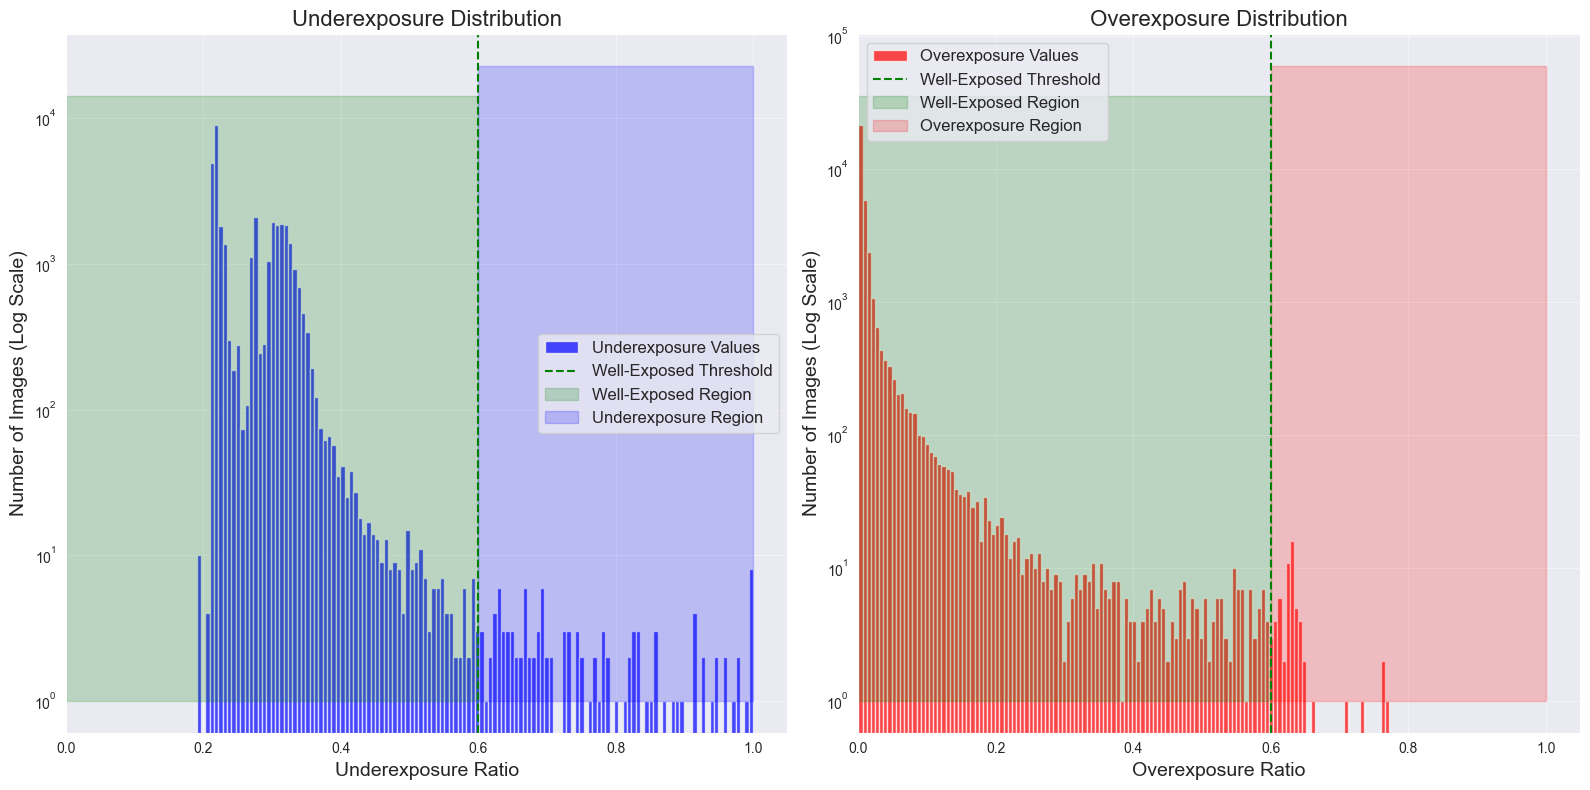

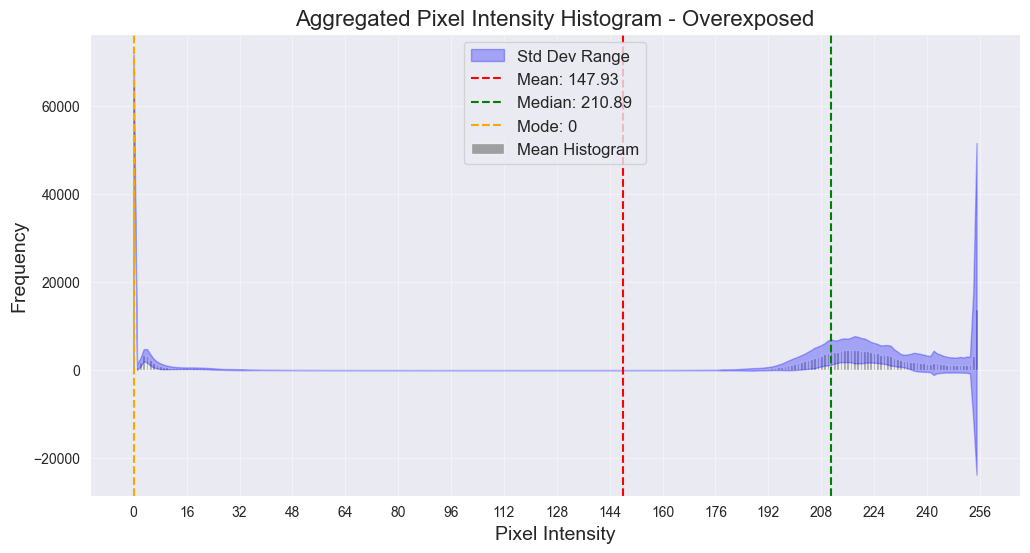

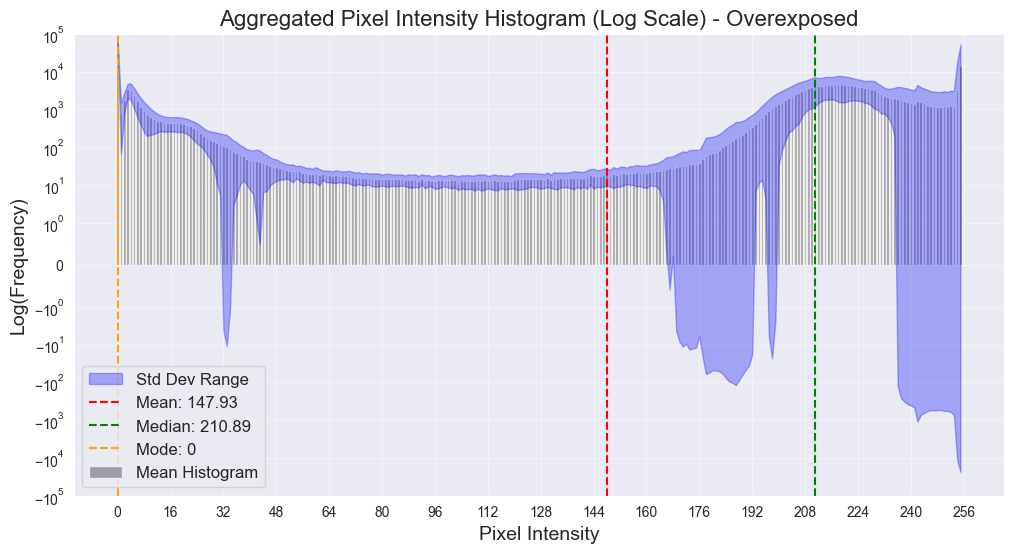

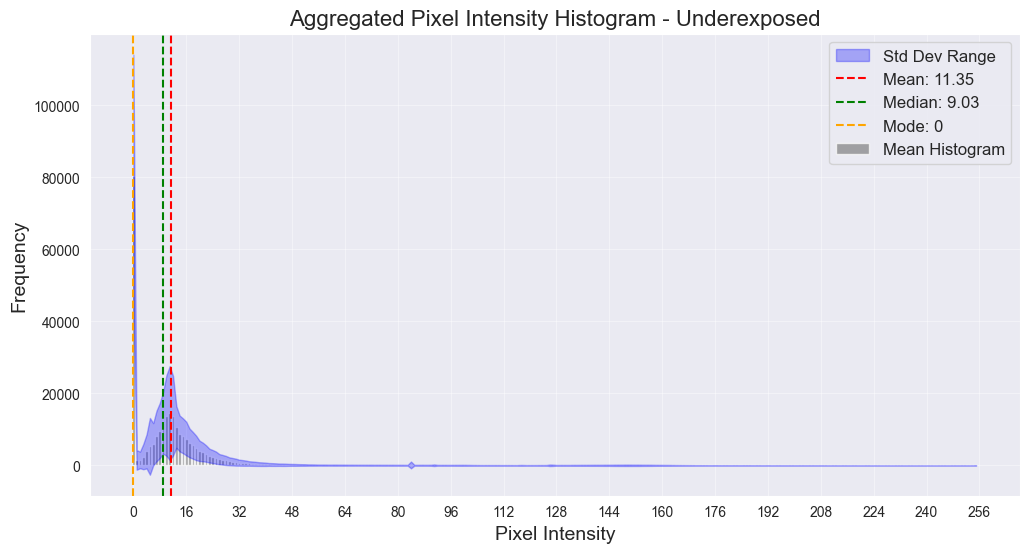

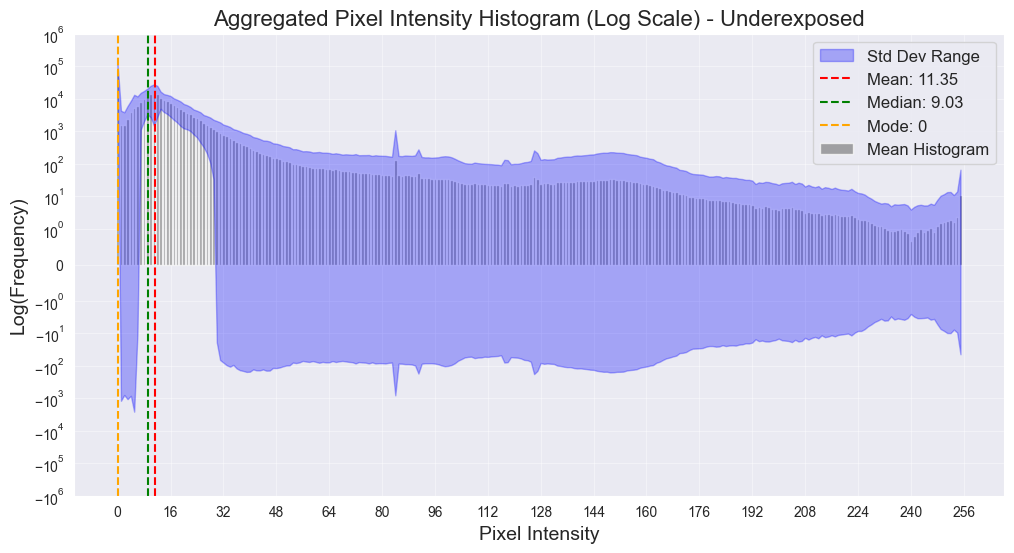

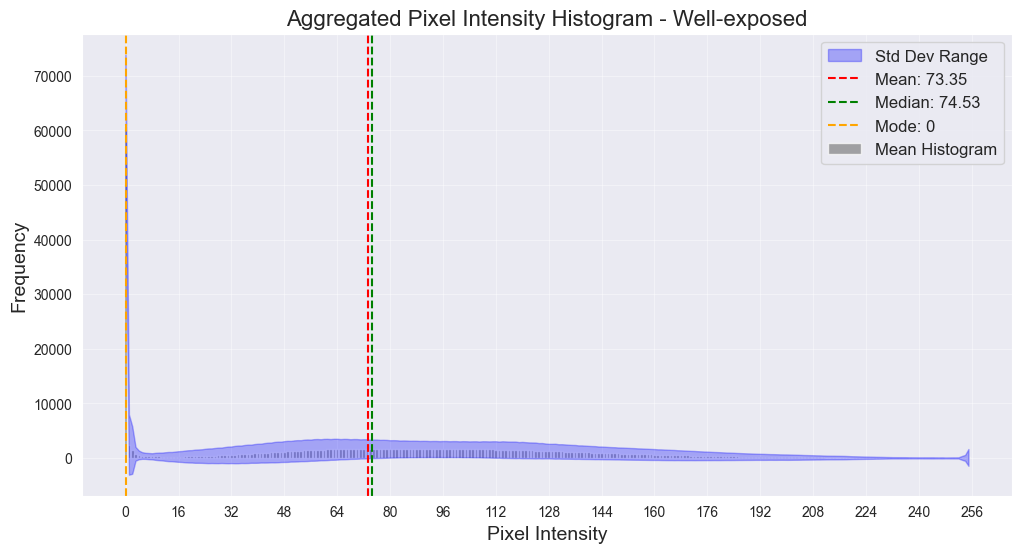

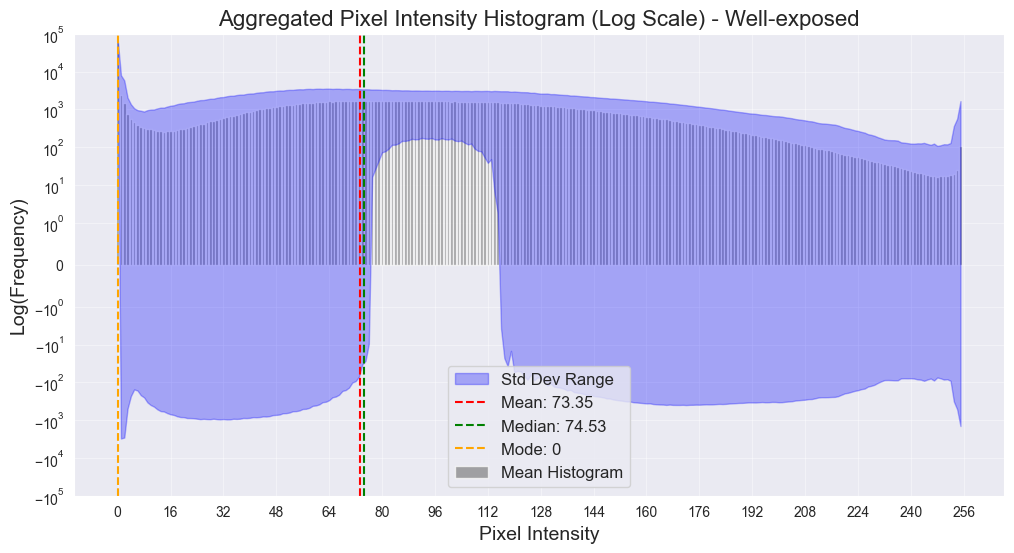

C:\Users\gabiy\AppData\Local\Temp\ipykernel_8860\1330779769.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = dataframe.groupby("label", group_keys=False).apply(
 23%|██▎       | 146/640 [00:00<00:01, 294.09it/s]

Image not found: Data/Preprocessed\Well-exposed\41889_right.jpeg


 41%|████▏     | 264/640 [00:00<00:01, 284.89it/s]

Image not found: Data/Preprocessed\Well-exposed\4831_right.jpeg
Image not found: Data/Preprocessed\Well-exposed\12329_left.jpeg


100%|██████████| 640/640 [00:02<00:00, 289.89it/s]


Image not found: Data/Preprocessed\Well-exposed\41761_left.jpeg


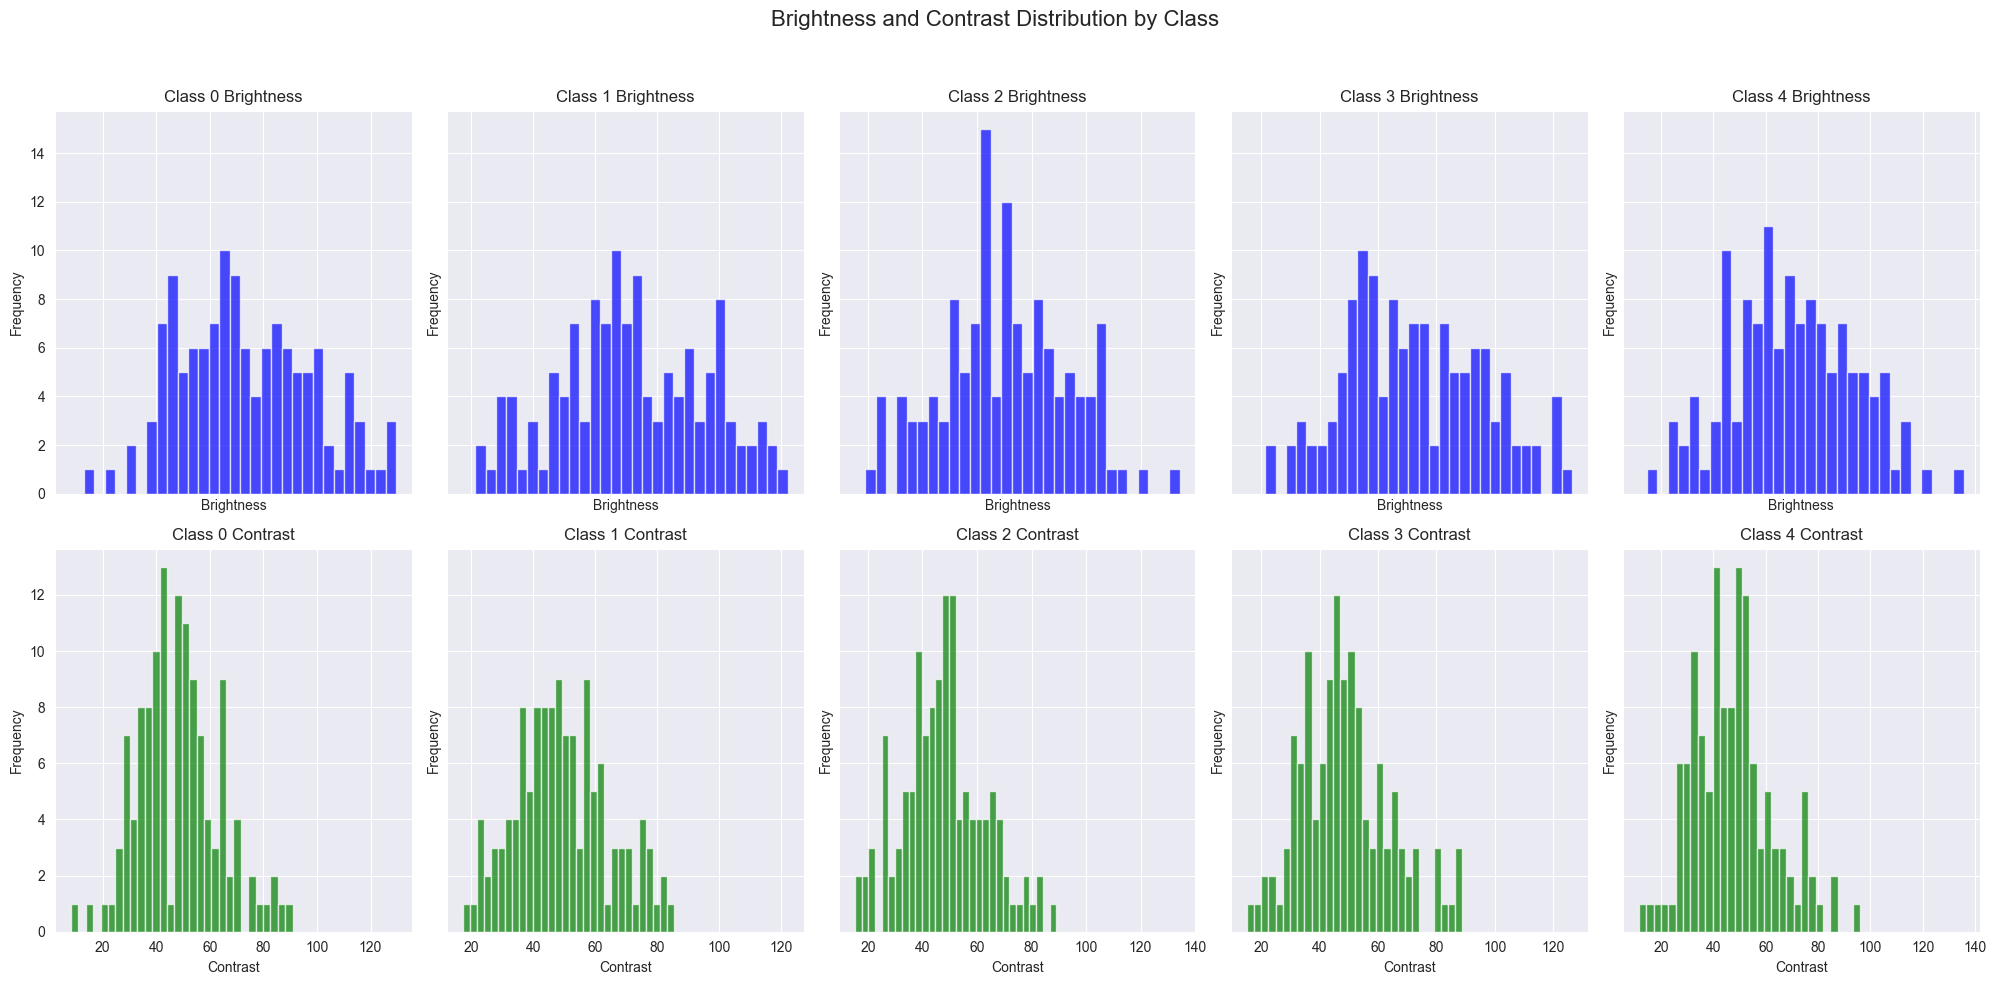

In [46]:
if __name__ == '__main__':
    
    image_folder = 'Data/train'
    output_folder = 'Data/Preprocessed' 
    csv_path = 'Data/trainLabels.csv'
    
    process_and_visualize_images(image_folder, output_folder, csv_path)
    

In [47]:
# # Load CSV and associate image paths
# def load_data(csv_path, image_folder):
#     df = pd.read_csv(csv_path)
#     df["image_path"] = df["image"].apply(lambda x: os.path.join(image_folder, f"{x}.jpeg"))
#     return df

In [48]:
# # Split data into Train, Validation, and Test sets
# def split_data(df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
#     assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."
#     
#     # First split into Train and Temp (Val + Test)
#     train_df, temp_df = train_test_split(df, 
#         test_size=(1 - train_ratio), 
#         stratify=df["level"], 
#         random_state=random_state)
#     
#     # Then split Temp into Validation and Test
#     val_df, test_df = train_test_split(temp_df, 
#         test_size=(test_ratio / (val_ratio + test_ratio)), 
#         stratify=temp_df["level"], 
#         random_state=random_state)
#     
#     return train_df, val_df, test_df

In [49]:
# # Load images into memory
# def load_images(df):
#     images = []
#     labels = []
#     for _, row in df.iterrows():
#         image_path = row["image_path"]
#         label = row["level"]
#         try:
#             # Load image and convert to RGB
#             image = Image.open(image_path).convert("RGB")
#             images.append(image)
#             labels.append(label)
#         except Exception as e:
#             print(f"Error loading image {image_path}: {e}")
#     return images, labels

In [50]:
# # Main script
# if __name__ == "__main__":
#     csv_path = "trainLabels.csv"
#     image_folder = "Cropped_W_Exposure"
#     
#     # Load dataset
#     df = load_data(csv_path, image_folder)
#     
#     # Split dataset
#     train_df, val_df, test_df = split_data(df)
#     
#     print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")
#     
#     # Load images into memory
#     train_images, train_labels = load_images(train_df)
#     val_images, val_labels = load_images(val_df)
#     test_images, test_labels = load_images(test_df)
#     
#     print(f"Loaded {len(train_images)} train images, {len(val_images)} validation images, {len(test_images)} test images.")

Computing Fourier features: 100%|██████████| 34955/34955 [04:00<00:00, 145.17it/s]


Features saved to fourier_features_with_labels.csv


Statistical Comparison via ANOVA: 100%|██████████| 5/5 [00:00<00:00, 138.21it/s]

ANOVA for MeanMagnitude: F-stat = 44.3775, p-value = 3.1818e-37
ANOVA for VarianceMagnitude: F-stat = 18.7214, p-value = 2.1885e-15
ANOVA for HighFreqEnergy: F-stat = 41.0546, p-value = 2.1958e-34
ANOVA for LowFreqEnergy: F-stat = 42.2605, p-value = 2.0486e-35
ANOVA for EnergyRatio: F-stat = 23.1353, p-value = 4.0266e-19


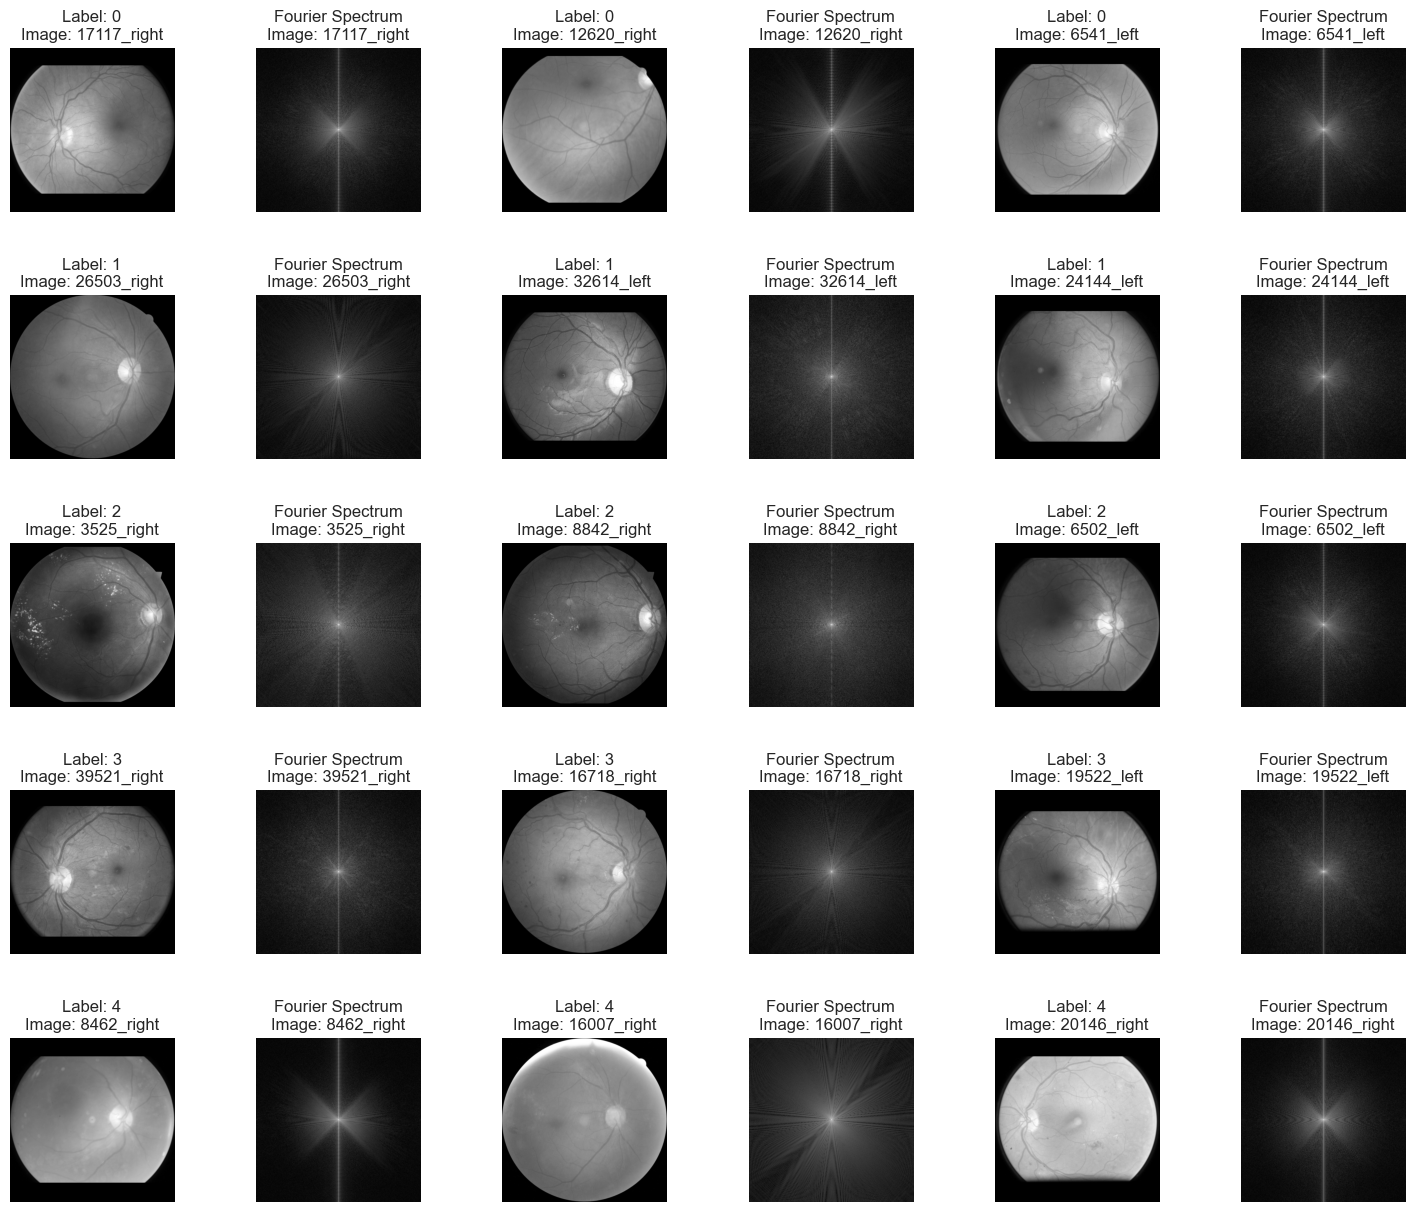

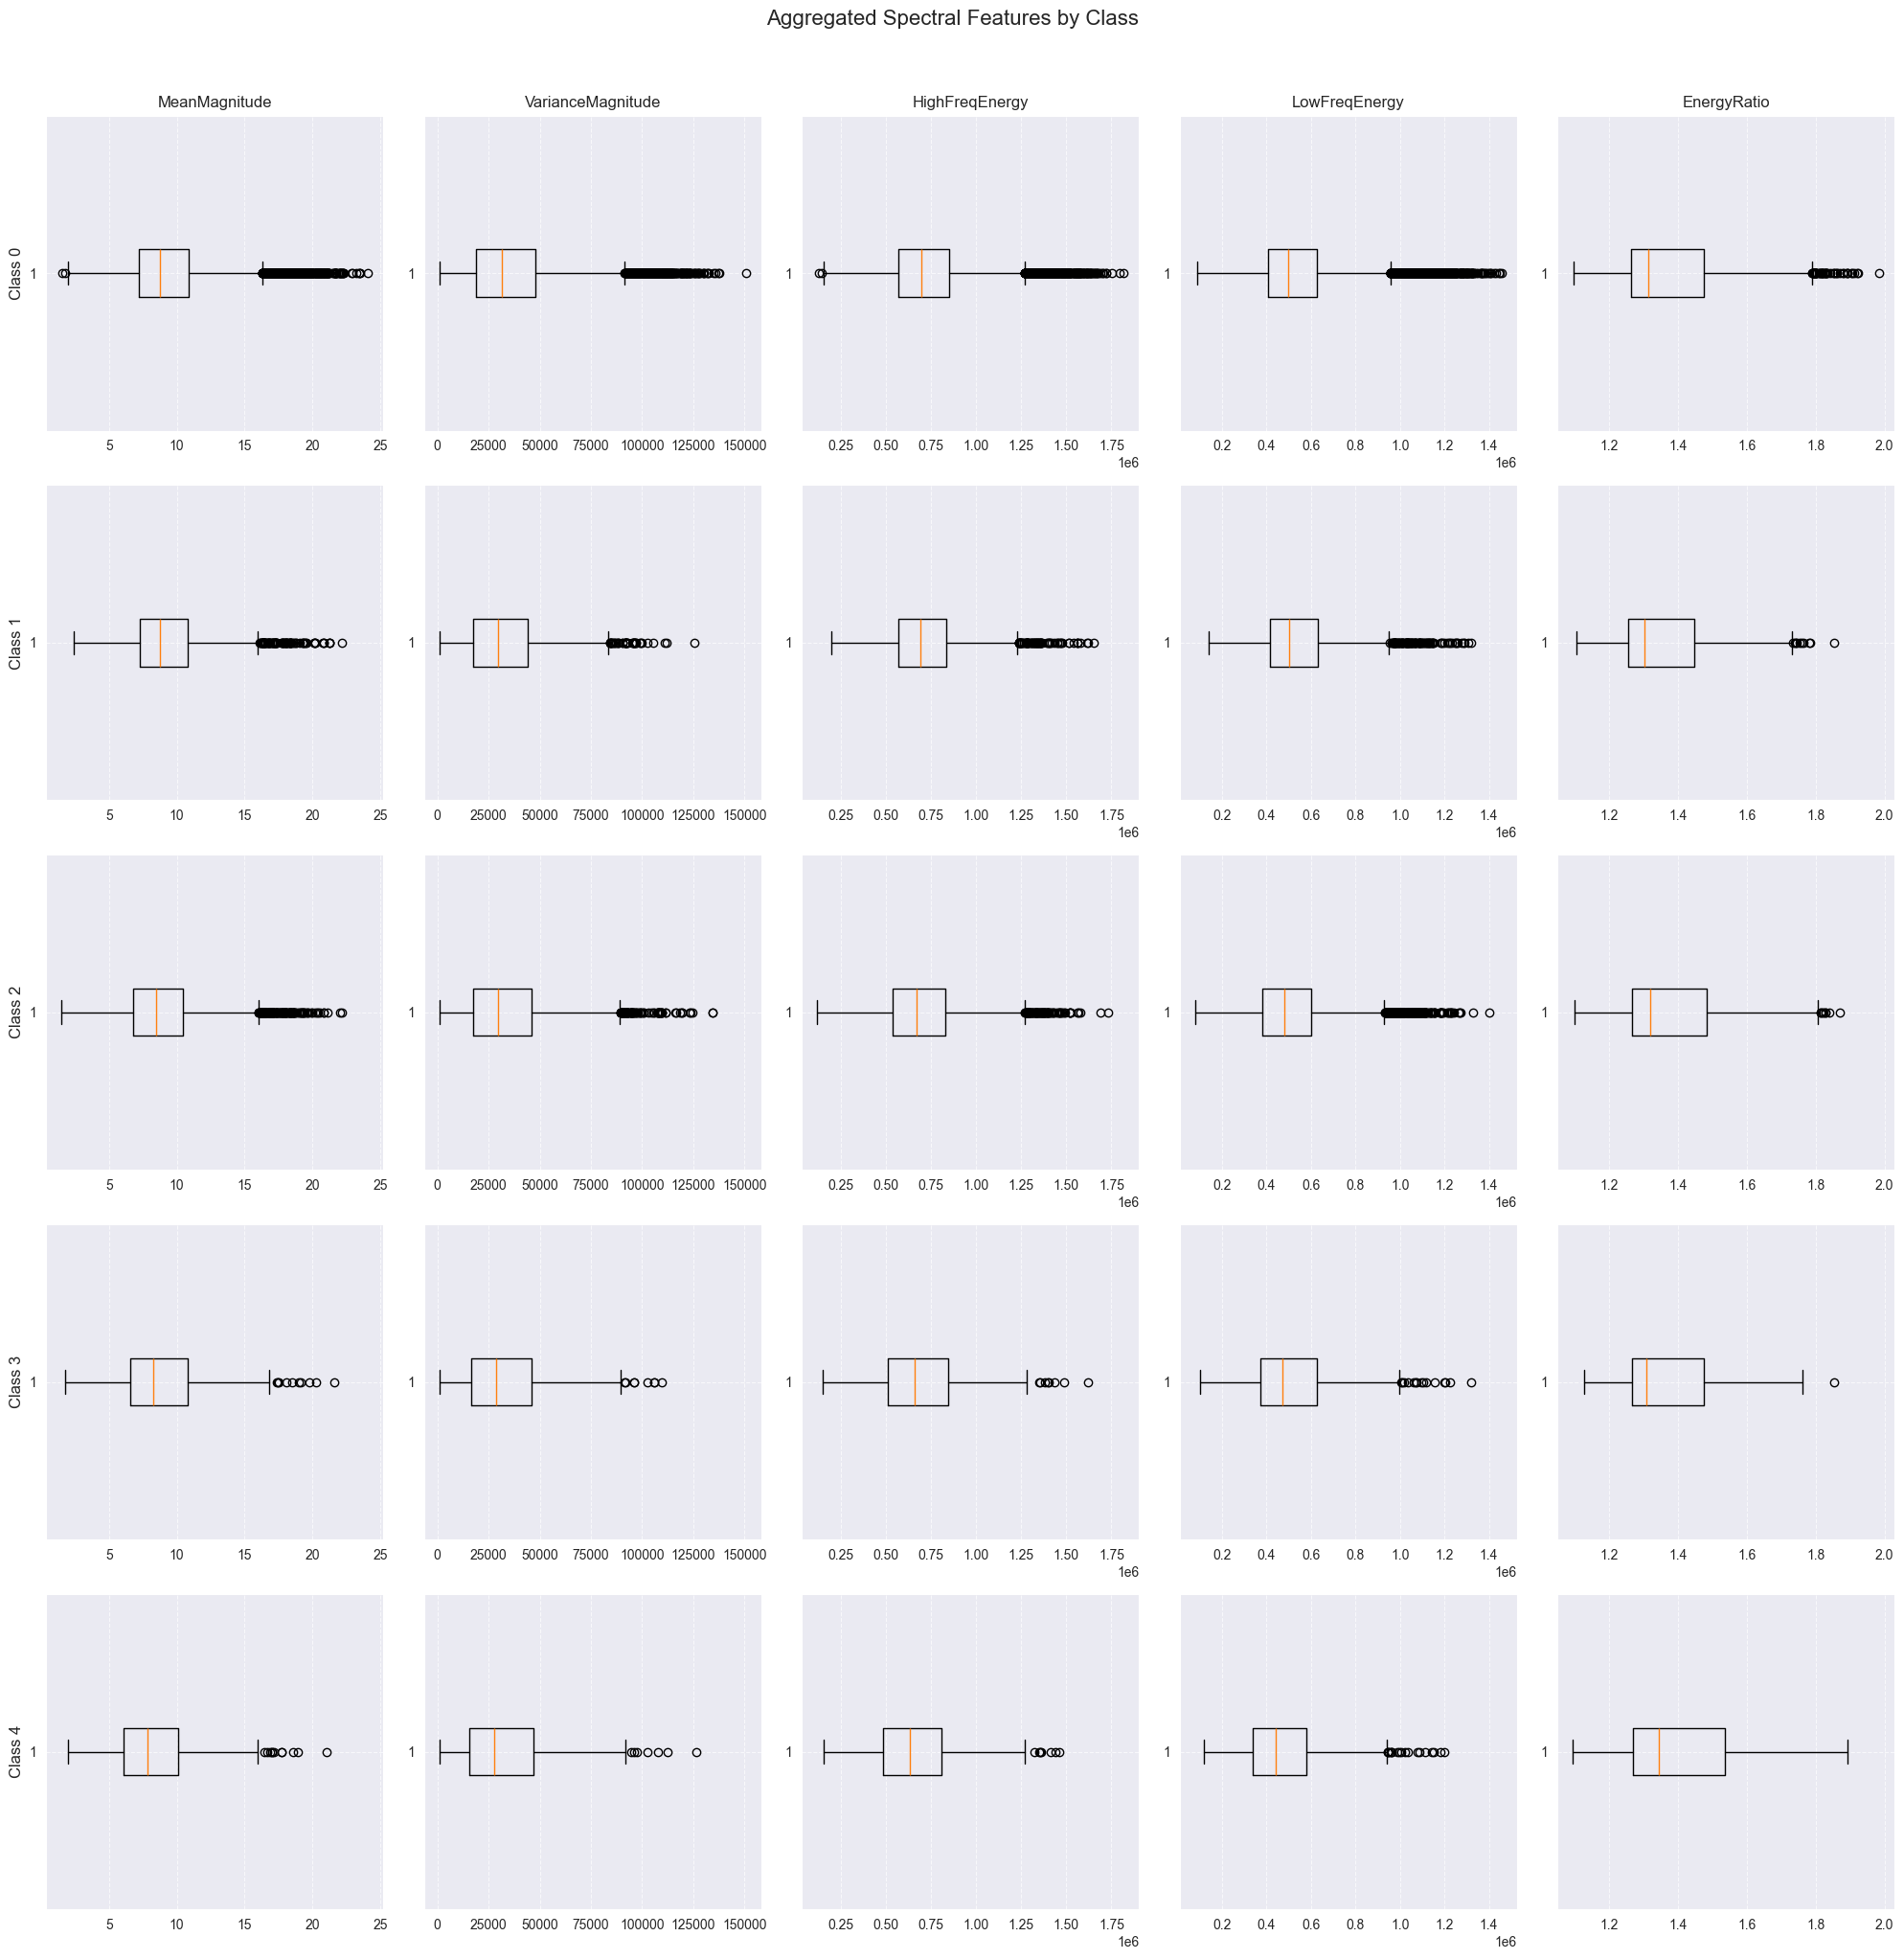

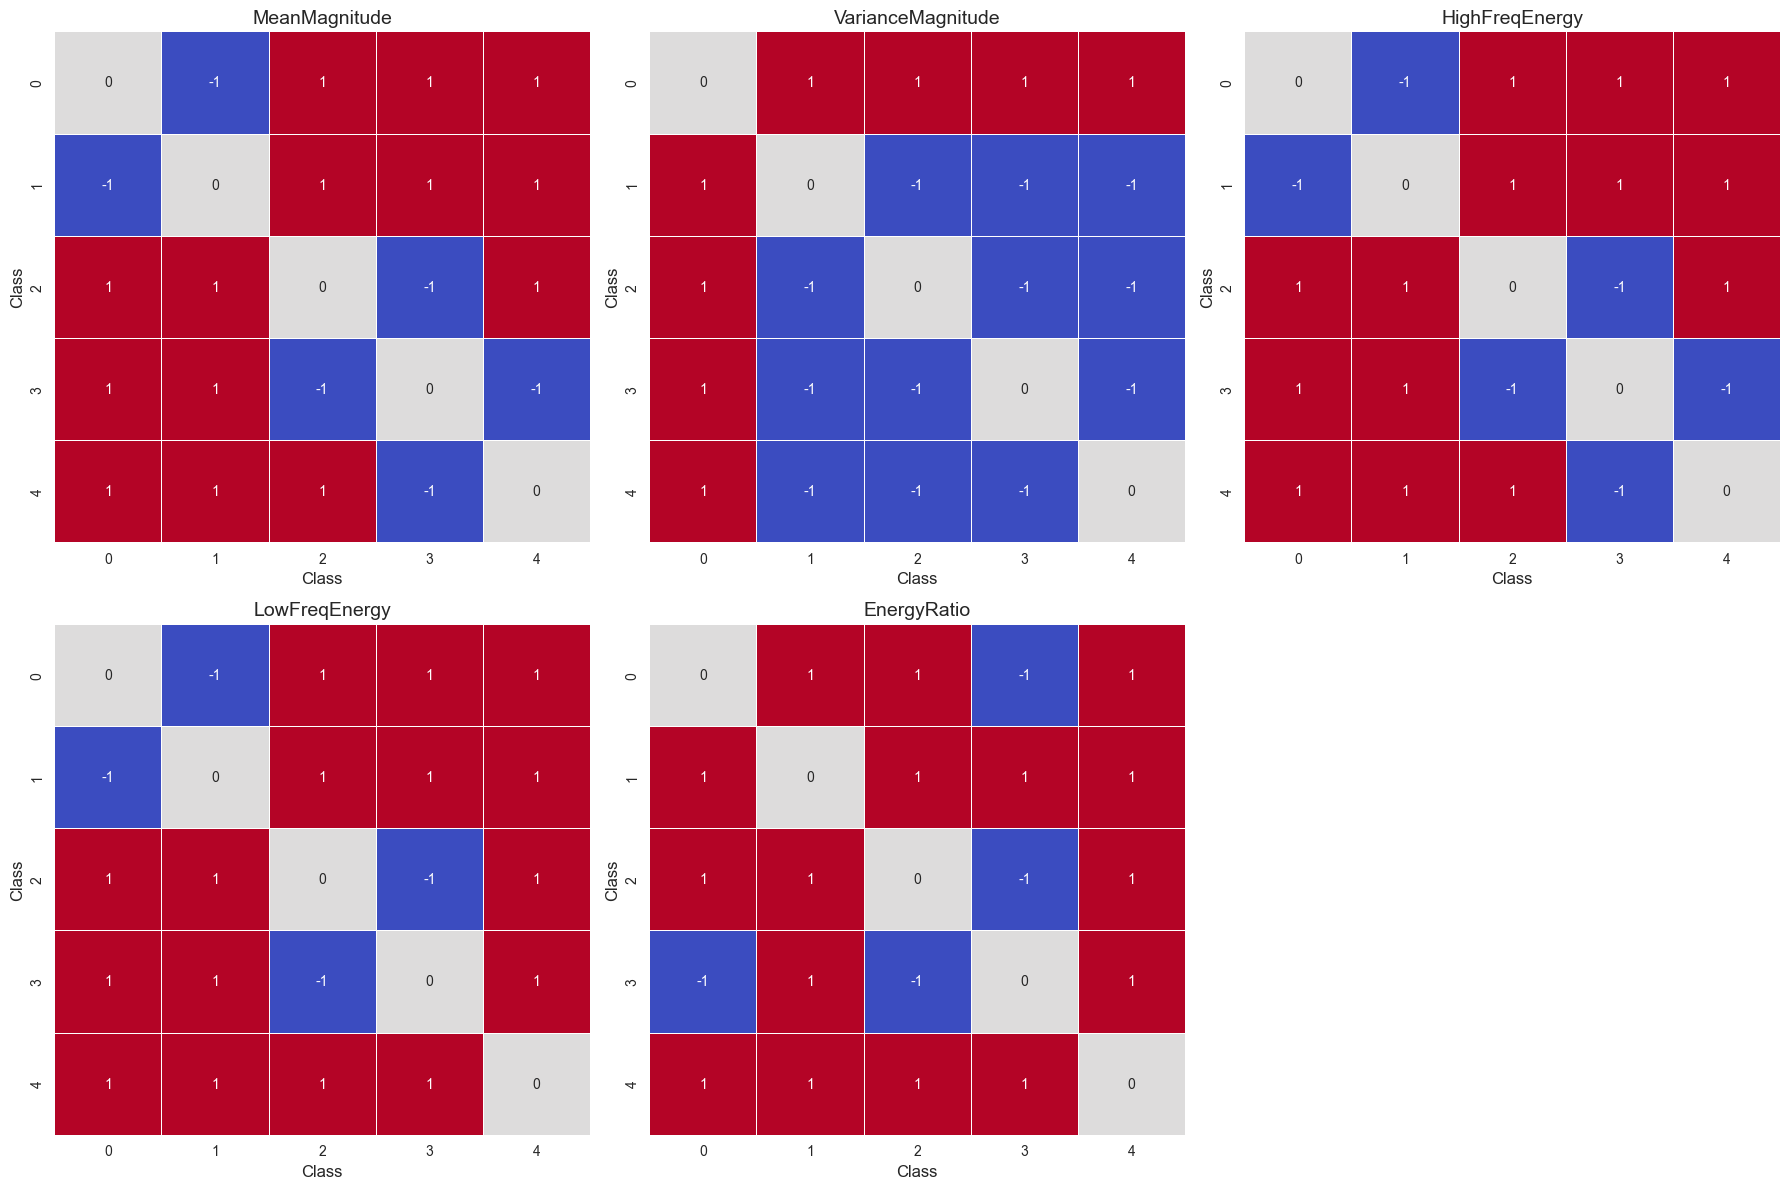

Processing class 3: 100%|██████████| 873/873 [00:10<00:00, 81.35it/s]


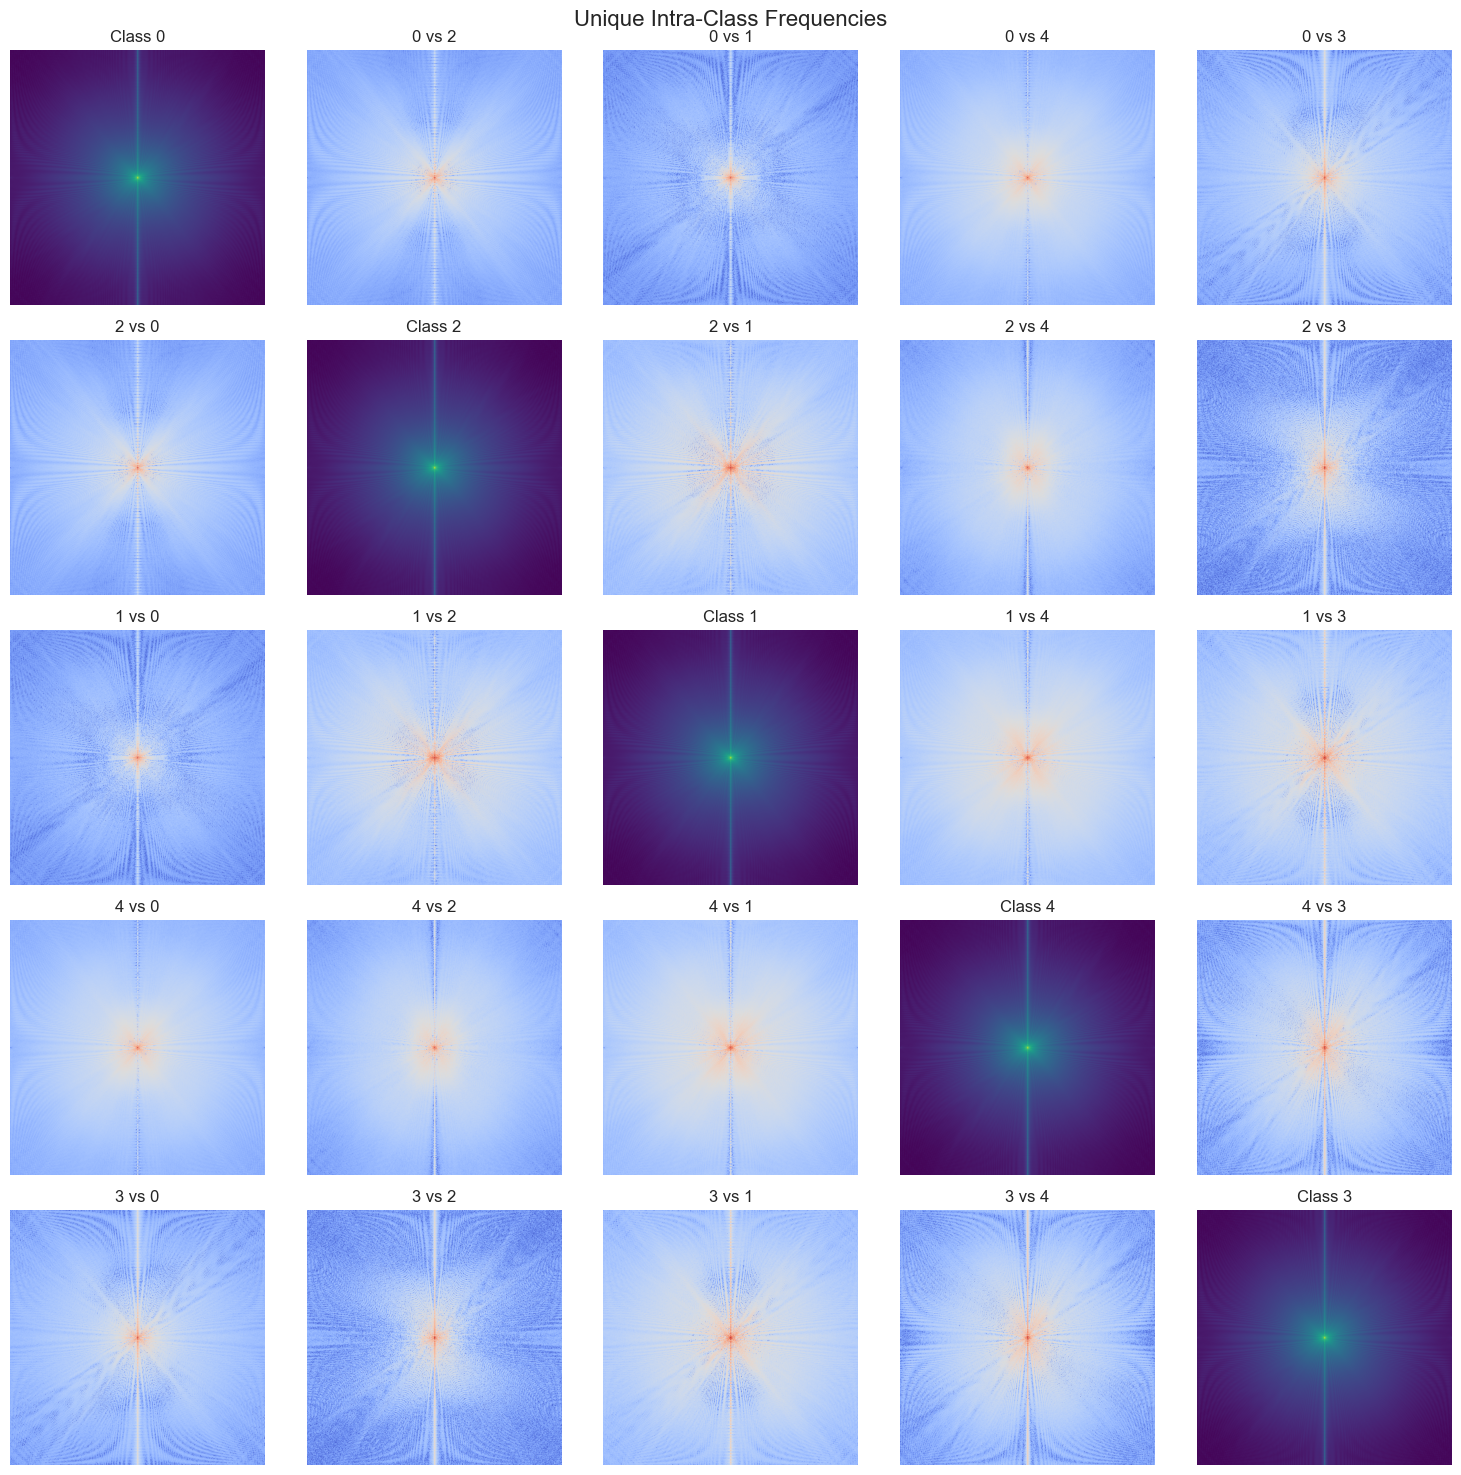

In [51]:
def get_or_compute_fft(image_path, cache_dir="fft_cache"):
    """
    Compute the 2D Fourier Transform (with shift) of a grayscale image.
    If the result is cached, load it directly from disk.

    Parameters:
        image_path (str): Full path to the image file.
        cache_dir (str): Directory to store cached FFT results.

    Returns:
        np.ndarray: 2D Fourier Transform (shifted) of the image.
    """
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Construct cache file path
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    cache_file = os.path.join(cache_dir, f"{base_name}.npy")

    # If cached result exists, load it
    if os.path.exists(cache_file):
        fft_shift = np.load(cache_file)
        return fft_shift

    # Otherwise, read the image, compute FFT, and cache the result
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    
    # Convert to grayscale and float32 in [0,1]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    
    # Compute FFT and shift
    fft_result = fft2(img_gray)
    fft_shift = fftshift(fft_result)

    # Save to cache
    np.save(cache_file, fft_shift)

    return fft_shift


def process_images_with_fourier_and_labels(path, dataframe, output_features_file="fourier_features_with_labels.csv", cache_dir="fft_cache"):
    """
    Process images to extract Fourier features and associate them with labels from the provided dataframe.
    
    Parameters:
        path (str): Path to the dataset containing images ('Well-exposed' subfolder).
        dataframe (pd.DataFrame): DataFrame containing 'image' and 'label' columns.
        output_features_file (str): File path to save the extracted features.
        cache_dir (str): Directory to store or retrieve cached FFT results.
        
    Returns:
        pd.DataFrame: DataFrame containing Fourier features and associated labels.
    """
    image_path = os.path.join(path, 'Well-exposed')
    features = []
    
    for image_file in tqdm(os.listdir(image_path), desc="Computing Fourier features"):
        # Remove the extension to find the label
        image_name_no_ext = os.path.splitext(image_file)[0]
        
        # Find the label in the dataframe
        label_row = dataframe[dataframe['image'] == image_name_no_ext]
        if label_row.empty:
            print(f"Warning: No label found for {image_file}. Skipping.")
            continue
        label = label_row['label'].values[0]
        
        # Full path to the current image
        full_img_path = os.path.join(image_path, image_file)
        if not os.path.exists(full_img_path):
            print(f"Warning: File {full_img_path} does not exist. Skipping.")
            continue
        
        # Get or compute the shifted FFT
        try:
            fft_shift = get_or_compute_fft(full_img_path, cache_dir=cache_dir)
        except FileNotFoundError as e:
            print(e)
            continue
        
        # Compute the magnitude spectrum
        magnitude_spectrum = np.abs(fft_shift)
        
        # Extract Fourier-based features
        mean_magnitude = np.mean(magnitude_spectrum)
        variance_magnitude = np.var(magnitude_spectrum)
        
        # Simple partition of frequency domain into "low" (top-left quadrant)
        # and "high" (bottom-right quadrant) for demonstration
        h, w = magnitude_spectrum.shape
        high_freq_energy = np.sum(magnitude_spectrum[h//2:, w//2:])
        low_freq_energy = np.sum(magnitude_spectrum[:h//2, :w//2])
        energy_ratio = high_freq_energy / (low_freq_energy + 1e-8)  # Avoid division by zero
        
        features.append([
            image_name_no_ext, 
            label, 
            mean_magnitude, 
            variance_magnitude, 
            high_freq_energy, 
            low_freq_energy, 
            energy_ratio
        ])
    
    # Create a DataFrame and save
    columns = ["image", "label", "MeanMagnitude", "VarianceMagnitude", 
               "HighFreqEnergy", "LowFreqEnergy", "EnergyRatio"]
    features_df = pd.DataFrame(features, columns=columns)
    features_df.to_csv(output_features_file, index=False)
    print(f"Features saved to {output_features_file}")
    
    return features_df


def statistical_comparison(df):
    """
    Perform ANOVA for each feature across classes.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing at least 'label' and numerical feature columns.
    """
    features = ["MeanMagnitude", "VarianceMagnitude", "HighFreqEnergy", "LowFreqEnergy", "EnergyRatio"]
    for feature in tqdm(features, desc="Statistical Comparison via ANOVA"):
        data_by_class = [df[df["label"] == lbl][feature] for lbl in df["label"].unique()]
        f_stat, p_value = f_oneway(*data_by_class)
        print(f"ANOVA for {feature}: F-stat = {f_stat:.4f}, p-value = {p_value:.4e}")


def visualize_fourier_examples_with_names(path, dataframe, num_examples=3, cache_dir="fft_cache"):
    """
    Visualize Fourier spectra for a few example images for each label in order,
    including the image name in the title.
    
    Parameters:
        path (str): Path to the dataset containing images ('Well-exposed' subfolder).
        dataframe (pd.DataFrame): DataFrame containing 'image' and 'label' columns.
        num_examples (int): Number of examples to visualize per label.
        cache_dir (str): Directory to store or retrieve cached FFT results.
    """
    image_path = os.path.join(path, 'Well-exposed')
    labels = sorted(dataframe['label'].unique())
    
    fig, axes = plt.subplots(len(labels), num_examples * 2, figsize=(num_examples * 6, len(labels) * 3))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for i, label in enumerate(labels):
        label_df = dataframe[dataframe['label'] == label]
        
        # Sample `num_examples` images for the current label
        sampled_images = label_df.sample(n=num_examples, random_state=42)
        
        for j, (_, row) in enumerate(sampled_images.iterrows()):
            image_name = row['image']
            image_file = f"{image_name}.jpeg"
            full_img_path = os.path.join(image_path, image_file)
            
            if not os.path.exists(full_img_path):
                print(f"Warning: Could not find {full_img_path}. Skipping.")
                continue
            
            # Retrieve (or compute) FFT
            try:
                fft_shift = get_or_compute_fft(full_img_path, cache_dir=cache_dir)
            except FileNotFoundError as e:
                print(e)
                continue

            magnitude_spectrum = np.abs(fft_shift)
            log_spectrum = np.log1p(magnitude_spectrum)
            
            # Read the image for display
            img = cv2.imread(full_img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Could not read {full_img_path}. Skipping.")
                continue
            
            # Show the original image
            ax_img = axes[i, j*2]
            ax_img.imshow(img, cmap='gray')
            ax_img.set_title(f'Label: {label}\nImage: {image_name}')
            ax_img.axis('off')
            
            # Show the Fourier spectrum (log scale)
            ax_spectrum = axes[i, j*2 + 1]
            ax_spectrum.imshow(log_spectrum, cmap='gray')
            ax_spectrum.set_title(f'Fourier Spectrum\nImage: {image_name}')
            ax_spectrum.axis('off')
    
    plt.show()

def plot_aggregated_spectral_features(features_df):
    """
    Plot aggregated spectral features for each class in a subplot layout with normalized x-axes per column.

    Parameters:
        features_df (pd.DataFrame): DataFrame containing spectral features with columns:
                                   'label', 'MeanMagnitude', 'VarianceMagnitude',
                                   'HighFreqEnergy', 'LowFreqEnergy', 'EnergyRatio'.
    """
    feature_columns = [
        "MeanMagnitude",
        "VarianceMagnitude",
        "HighFreqEnergy",
        "LowFreqEnergy",
        "EnergyRatio"
    ]
    class_labels = sorted(features_df['label'].unique())
    num_classes = len(class_labels)
    
    # Create figure and axes
    fig, axes = plt.subplots(nrows=num_classes, ncols=len(feature_columns), 
                            figsize=(20, 4 * num_classes))
    fig.suptitle("Aggregated Spectral Features by Class", fontsize=16, y=1.02)
    
    # First pass: Find min and max values for each feature
    feature_ranges = {}
    for feature in feature_columns:
        min_val = features_df[feature].min()
        max_val = features_df[feature].max()
        # Add a small buffer (5%) to the range
        range_buffer = (max_val - min_val) * 0.05
        feature_ranges[feature] = (min_val - range_buffer, max_val + range_buffer)
    
    # Second pass: Create plots with normalized axes
    for i, label in enumerate(class_labels):
        class_data = features_df[features_df['label'] == label]
        
        for j, feature in enumerate(feature_columns):
            ax = axes[i, j] if num_classes > 1 else axes[j]
            
            # Create boxplot
            ax.boxplot(class_data[feature], vert=False)
            
            # Set consistent x-axis limits for this feature
            ax.set_xlim(feature_ranges[feature])
            
            # Add labels
            if i == 0:
                ax.set_title(feature, fontsize=12)
            if j == 0:
                ax.set_ylabel(f"Class {label}", fontsize=12)
            
            # Add grid for better readability
            ax.grid(True, linestyle='--', alpha=0.7)
            
            # Format axis ticks
            ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()

def perform_tukey_posthoc_with_heatmap(data, label_column='label'):
    """
    Perform Tukey's post-hoc analysis for all numerical features in the dataset and plot heatmaps.

    Parameters:
    - data (pd.DataFrame): Data containing features and labels.
    - label_column (str): Column name of the class labels.

    Returns:
    - dict: Dictionary containing Tukey test results for each feature.
    """
    features_to_analyze = data.select_dtypes(include=[np.number]).columns.drop(label_column)
    class_labels = data[label_column].unique()
    class_labels.sort()
    num_classes = len(class_labels)
    tukey_results = {}
    heatmaps_data = {}

    for feature in features_to_analyze:
        tukey = pairwise_tukeyhsd(endog=data[feature], groups=data[label_column], alpha=0.05)
        df_tukey = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        tukey_results[feature] = df_tukey

        # Build matrix for heatmap
        heatmap_matrix = np.zeros((num_classes, num_classes), dtype=int)
        for _, row in df_tukey.iterrows():
            g1, g2, p_value = int(row["group1"]), int(row["group2"]), row["p-adj"]
            if p_value < 0.05:
                heatmap_matrix[g1, g2] = 1
                heatmap_matrix[g2, g1] = 1
            else:
                heatmap_matrix[g1, g2] = -1
                heatmap_matrix[g2, g1] = -1

        np.fill_diagonal(heatmap_matrix, 0)
        heatmaps_data[feature] = heatmap_matrix

    # Plot heatmaps
    num_features = len(features_to_analyze)
    rows = (num_features + 2) // 3  # up to 3 columns per row
    fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axes = axes.flatten() if rows > 1 else axes

    for i, feature in enumerate(features_to_analyze):
        sns.heatmap(
            heatmaps_data[feature], 
            annot=True, 
            cbar=False, 
            xticklabels=class_labels, 
            yticklabels=class_labels, 
            ax=axes[i], 
            cmap="coolwarm", 
            linewidths=0.5, 
            center=0, 
            vmin=-1, 
            vmax=1
        )
        axes[i].set_title(feature, fontsize=14)
        axes[i].set_xlabel("Class", fontsize=12)
        axes[i].set_ylabel("Class", fontsize=12)

    # Remove any unused subplots
    for j in range(len(features_to_analyze), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return tukey_results


def compute_average_fourier(path, labels_df, target_size=(512, 512), cache_dir="fft_cache"):
    """
    Compute average Fourier magnitude spectrum for each class.

    Parameters:
        path (str): Base directory containing images.
        labels_df (pd.DataFrame): DataFrame containing 'image' and 'label' columns.
        target_size (tuple): Size to resize images for consistency.
        cache_dir (str): Directory to store or retrieve cached FFT results.

    Returns:
        dict: A dictionary where keys are class labels and values are average Fourier spectra.
    """
    class_fourier = {}
    classes = labels_df['label'].unique()
    well_exposed_path = os.path.join(path, 'Well-exposed')
    
    for cls in classes:
        class_images = labels_df[labels_df['label'] == cls]['image']
        accumulated_magnitude = None
        count = 0
        
        for img_name in tqdm(class_images, desc=f"Processing class {cls}"):
            img_file = os.path.join(well_exposed_path, f"{img_name}.jpeg")
            if not os.path.exists(img_file):
                # print(f"Warning: File {img_file} does not exist.")
                continue
            
            # Optionally, read and resize for consistency in shape
            img = cv2.imread(img_file, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Warning: Could not read {img_file}.")
                continue
            img_resized = cv2.resize(img, target_size)
            gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

            # Instead of computing FFT from scratch, you could cache the resized version.
            # For simplicity, we'll compute it here each time (resize changes shape).
            fft_result = fft2(gray_img)
            fft_shifted = fftshift(fft_result)
            magnitude = np.abs(fft_shifted)

            if accumulated_magnitude is None:
                accumulated_magnitude = magnitude
            else:
                accumulated_magnitude += magnitude
            count += 1
        
        if count > 0:
            class_fourier[cls] = accumulated_magnitude / count
    
    return class_fourier


def visualize_unique_frequencies(class_fourier):
    """
    Visualize unique frequency patterns for each class.

    Parameters:
        class_fourier (dict): Dictionary of average Fourier spectra for each class.
    """
    classes = list(class_fourier.keys())
    n_classes = len(classes)
    
    fig, axes = plt.subplots(n_classes, n_classes, figsize=(15, 15))
    fig.suptitle("Unique Intra-Class Frequencies", fontsize=16)
    
    for i, class_i in enumerate(classes):
        for j, class_j in enumerate(classes):
            if i == j:
                # Diagonal: show the average spectrum for this class
                spectrum = class_fourier[class_i]
                axes[i, j].imshow(np.log1p(spectrum), cmap='viridis')
                axes[i, j].set_title(f"Class {class_i}")
            else:
                # Off-diagonal: show the difference spectrum
                diff_spectrum = class_fourier[class_i] - class_fourier[class_j]
                axes[i, j].imshow(np.log1p(np.abs(diff_spectrum)), cmap='coolwarm')
                axes[i, j].set_title(f"{class_i} vs {class_j}")
            
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    dataset_path = "Data/Preprocessed"
    labels_df = pd.read_csv("Data/Preprocessed/exposure_results_with_labels.csv")
    
    # 1. Compute and store Fourier features
    fourier_features_df = process_images_with_fourier_and_labels(dataset_path, labels_df)
    
    # 2. Statistical comparison
    statistical_comparison(fourier_features_df)
    
    # 3. Visualization of examples
    visualize_fourier_examples_with_names(dataset_path, labels_df)
    
    # 4. Aggregated spectral features
    plot_aggregated_spectral_features(fourier_features_df)
    
    # 5. Tukey post-hoc tests
    perform_tukey_posthoc_with_heatmap(fourier_features_df)
    
    # 6. Compute average spectra for each class
    class_fourier = compute_average_fourier(dataset_path, labels_df)
    visualize_unique_frequencies(class_fourier)

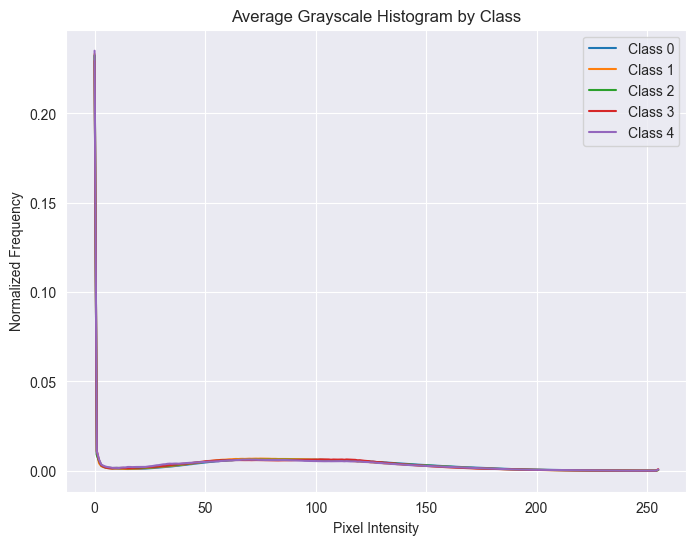


Computing per-channel statistics in parallel...


100%|██████████| 35126/35126 [1:21:23<00:00,  7.19it/s]  



=== Per-Class Channel Summary (Mean of Means) ===
   label     mean_b     mean_g     mean_r      std_b      std_g      std_r
0      0  41.768302  57.767846  82.650668  34.168909  47.073296  67.427921
1      1  38.614240  55.617664  80.404632  31.944947  45.605512  65.699803
2      2  39.505579  55.961958  78.818900  32.312335  46.052400  65.463255
3      3  37.114986  54.053999  77.209839  30.824373  45.200683  65.295214
4      4  40.080958  56.436962  77.227659  32.020460  45.398572  62.769368


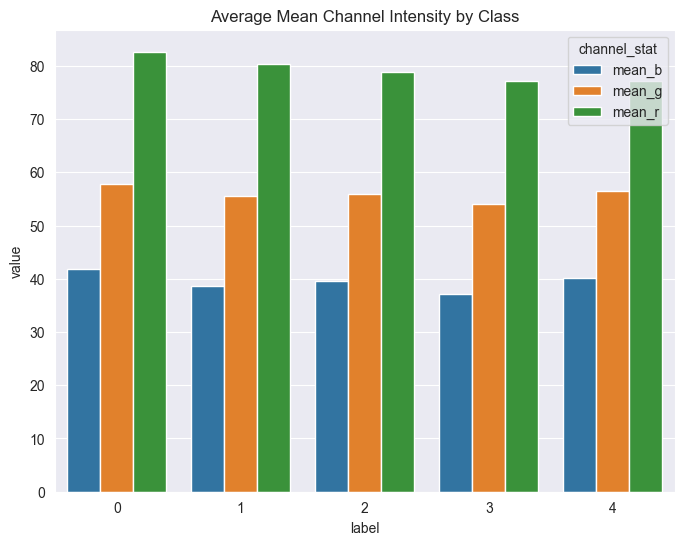

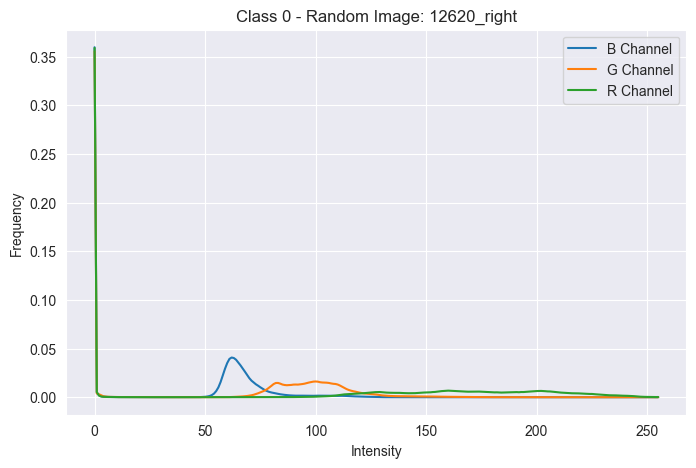

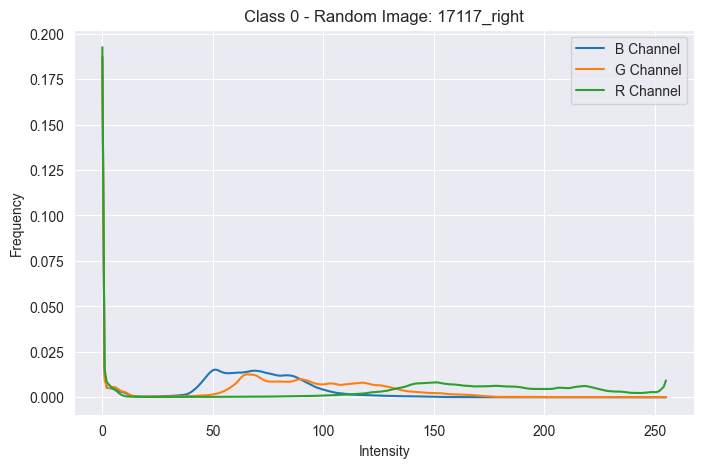

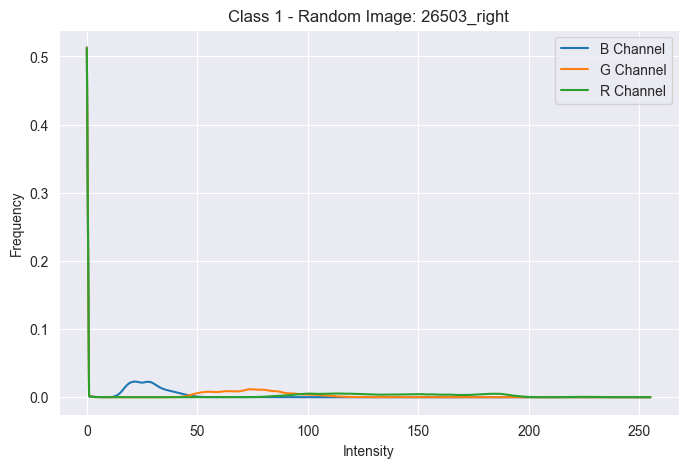

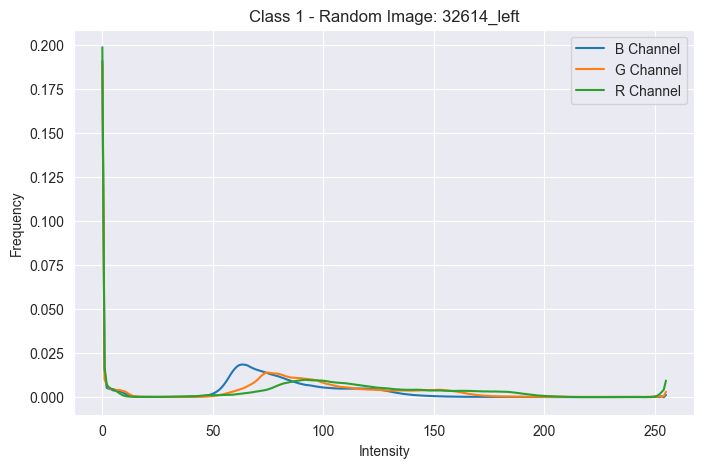

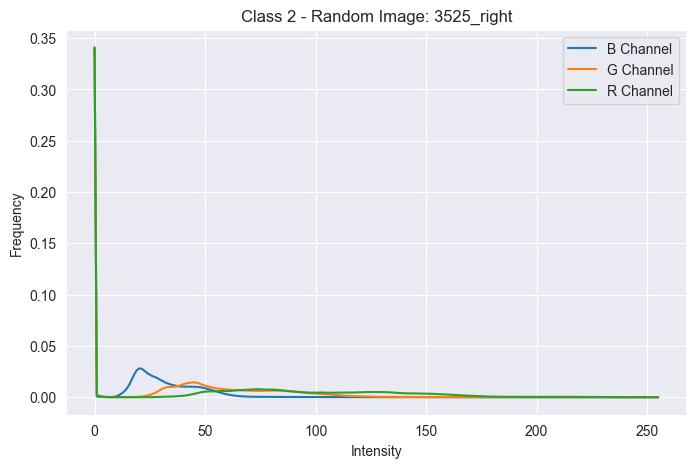

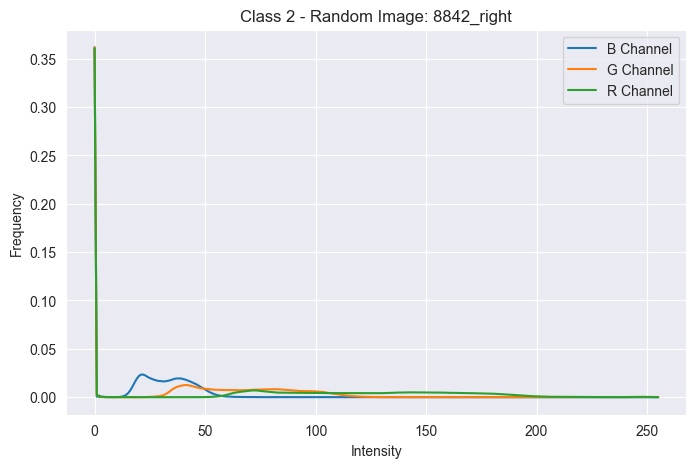

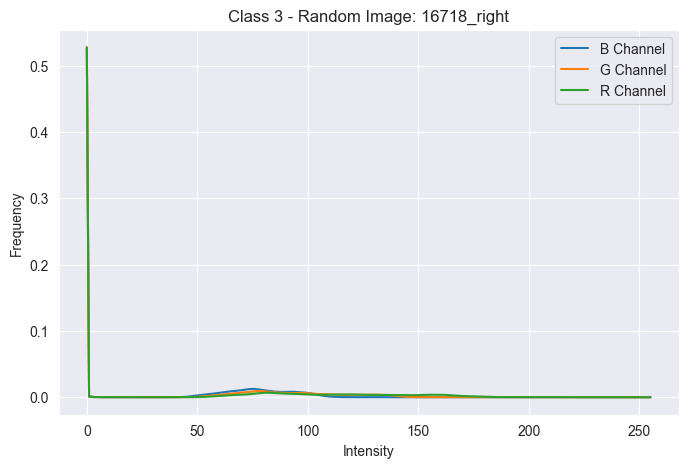

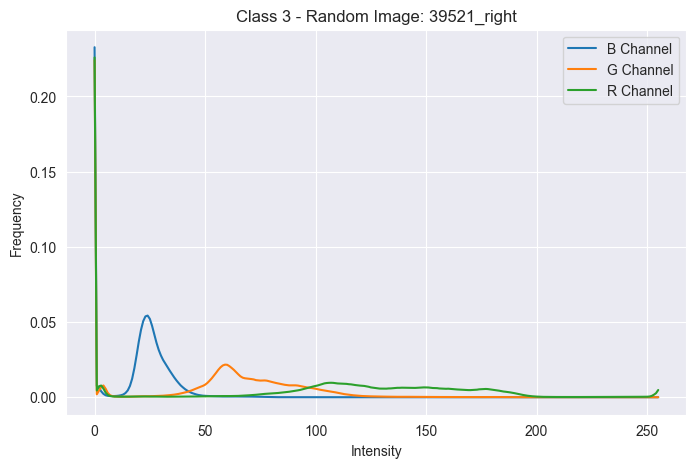

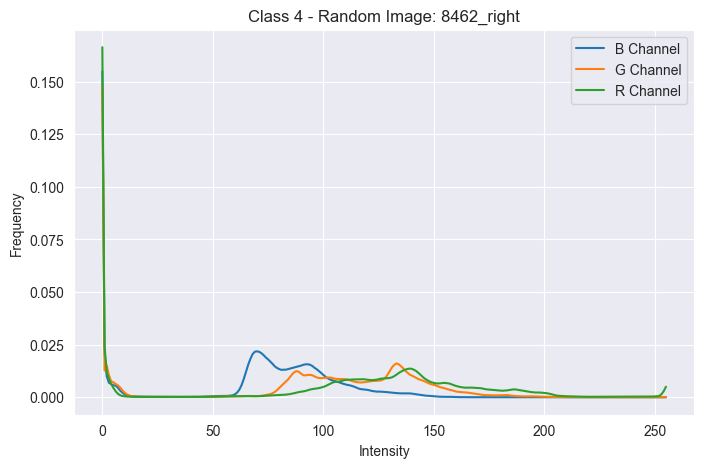

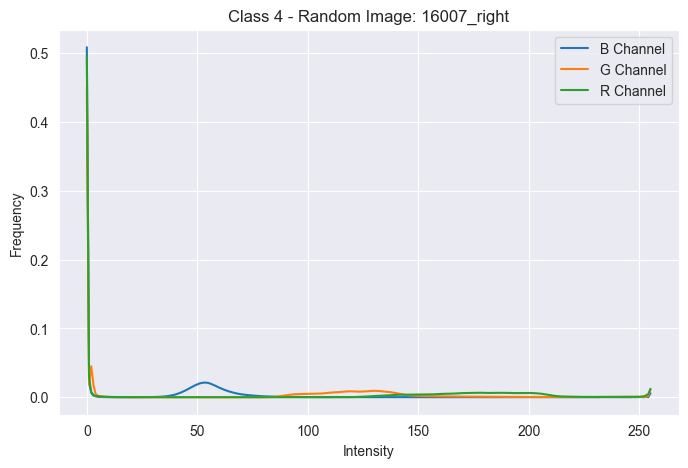

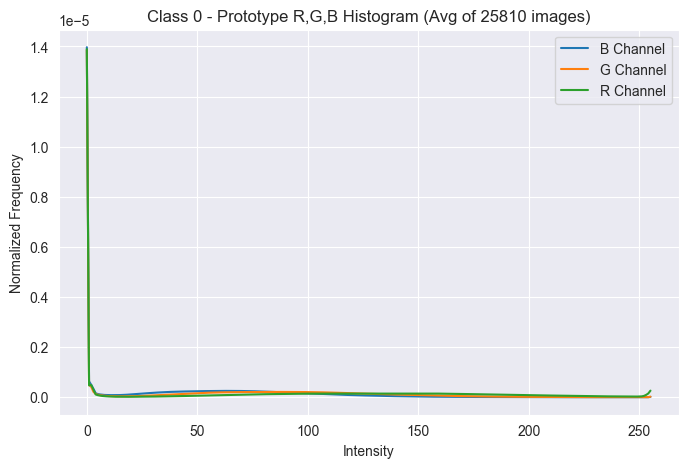

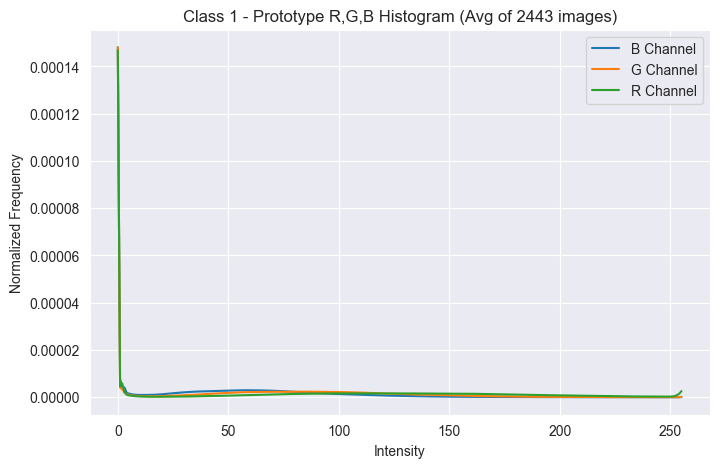

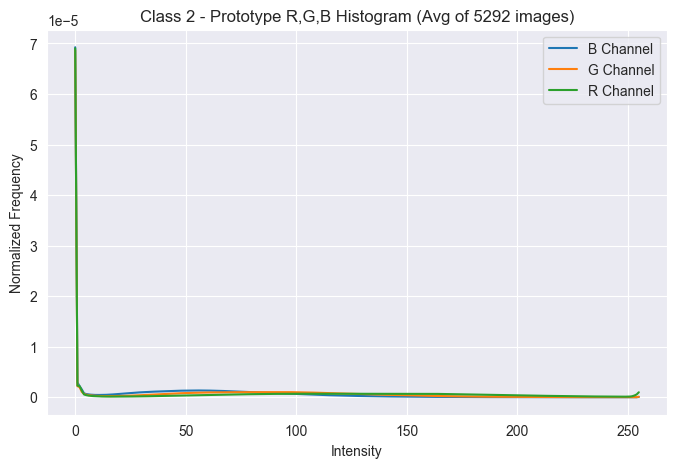

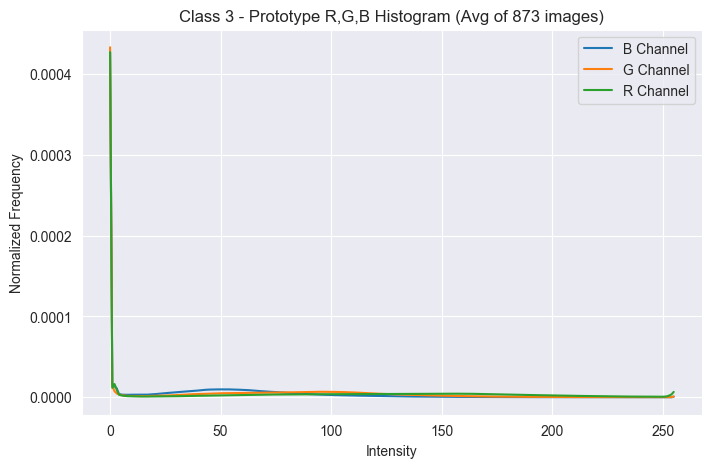

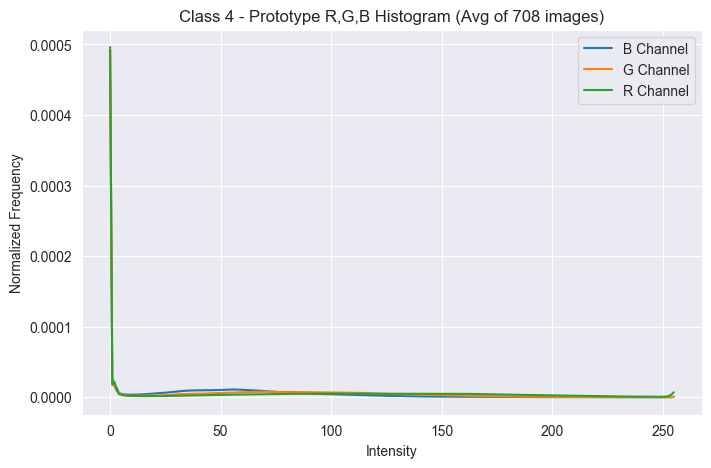

In [1]:
def compute_image_stats(args):
    """Helper function to compute statistics for a single image"""
    image_path, image_name, level = args
    img_bgr = cv2.imread(image_path)
    
    if img_bgr is None:
        return None
        
    # Split channels in BGR order
    b_channel, g_channel, r_channel = cv2.split(img_bgr)
    
    # Compute mean and std per channel
    stats = {'label': level,
             'image': image_name,
             'mean_b': b_channel.mean(),
             'std_b': b_channel.std(),
             'mean_g': g_channel.mean(),
             'std_g': g_channel.std(),
             'mean_r': r_channel.mean(),
             'std_r': r_channel.std()}
    
    # Compute RGB histogram
    hist_b = cv2.calcHist([img_bgr], [0], None, [256], [0,256]).ravel()
    hist_g = cv2.calcHist([img_bgr], [1], None, [256], [0,256]).ravel()
    hist_r = cv2.calcHist([img_bgr], [2], None, [256], [0,256]).ravel()
    
    stats['rgb_hist'] = {'b': hist_b,
                         'g': hist_g,
                         'r': hist_r}
    
    return stats

def analyze_global_pixel_intensity(csv_path, images_folder, num_random_images=2, bins=256, max_workers=None):
    """
    Parallel version of the image analysis function using ThreadPoolExecutor.
    
    Parameters
    ----------
    csv_path : str
        Path to the CSV file with 'image', 'label', 'histogram'.
    images_folder : str
        Path to the folder containing {image}.jpeg files.
    num_random_images : int, optional
        Number of random images to display histograms for each class.
    bins : int, optional
        Number of bins in the stored histogram.
    max_workers : int, optional
        Maximum number of threads to use. None means use default (usually CPU count * 5).
    """
    
    # Read the CSV file
    df = pd.read_csv(csv_path)
    df['hist_list'] = df['histogram'].apply(lambda x: ast.literal_eval(x))
    
    # 1. Aggregate Grayscale Histograms by Class
    class_hist = df.groupby('label')['hist_list'].apply(
        lambda hists: np.mean(np.array(list(hists)), axis=0))
    
    # Plot aggregated grayscale histogram
    plt.figure(figsize=(8, 6))
    intensity_bins = np.arange(bins)
    for level, hist_values in class_hist.items():
        hist_sum = np.sum(hist_values) if np.sum(hist_values) != 0 else 1
        normalized_hist = hist_values / hist_sum
        plt.plot(intensity_bins, normalized_hist, label=f"Class {level}")
    
    plt.title("Average Grayscale Histogram by Class")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.show()
    
    # 2. Parallel computation of per-channel statistics
    print("\nComputing per-channel statistics in parallel...")
    
    # Prepare arguments for parallel processing
    process_args = [
        (os.path.join(images_folder, f"{row['image']}.jpeg"), row['image'], row['label'])
        for _, row in df.iterrows()]
    
    stats_records = []
    prototype_hist = {cl: {'b': np.zeros(bins), 'g': np.zeros(bins), 'r': np.zeros(bins), 'count': 0}
                      for cl in sorted(df['label'].unique())}
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(compute_image_stats, args) for args in process_args]
        
        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            if result is not None:
                stats_records.append({k: v for k, v in result.items() if k != 'rgb_hist'})
                
                # Update prototype histograms
                cl = result['label']
                rgb_hist = result['rgb_hist']
                for channel in ['b', 'g', 'r']:
                    prototype_hist[cl][channel] += rgb_hist[channel]
                prototype_hist[cl]['count'] += 1
    
    # Create statistics DataFrame
    stats_df = pd.DataFrame(stats_records)
    
    # Aggregate by class
    channel_summary = stats_df.groupby('label').agg({
        'mean_b': 'mean', 'mean_g': 'mean', 'mean_r': 'mean',
        'std_b': 'mean', 'std_g': 'mean', 'std_r': 'mean'
    }).reset_index()
    
    print("\n=== Per-Class Channel Summary (Mean of Means) ===")
    print(channel_summary)
    
    # Plot channel means
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    wide_df = channel_summary.melt(id_vars=['label'],
                                   value_vars=['mean_b','mean_g','mean_r'],
                                   var_name='channel_stat',
                                   value_name='value')
    sns.barplot(x='label', y='value', hue='channel_stat', data=wide_df, ax=ax)
    ax.set_title("Average Mean Channel Intensity by Class")
    plt.show()
    
    # 3. Plot random examples and prototypes
    unique_classes = sorted(df['label'].unique())
    
    # Random examples
    for cl in unique_classes:
        class_df = df[df['label'] == cl]
        sample_rows = class_df.sample(min(num_random_images, len(class_df)), random_state=42)
        
        sample_stats = [
            result for result in stats_records 
            if result['image'] in sample_rows['image'].values]
        
        for stat in sample_stats:
            image_name = stat['image']
            img_path = os.path.join(images_folder, f"{image_name}.jpeg")
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                continue
                
            fig, ax = plt.subplots(1, 1, figsize=(8, 5))
            for channel, hist in compute_image_stats((img_path, image_name, cl))['rgb_hist'].items():
                norm = hist / (np.sum(hist) + 1e-8)
                ax.plot(range(bins), norm, label=f"{channel.upper()} Channel")
            
            ax.set_title(f"Class {cl} - Random Image: {image_name}")
            ax.set_xlabel("Intensity")
            ax.set_ylabel("Frequency")
            ax.legend()
            plt.show()
    
    # Plot class prototypes
    for cl in unique_classes:
        count = prototype_hist[cl]['count']
        if count == 0:
            continue
            
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        for channel in ['b', 'g', 'r']:
            avg_hist = prototype_hist[cl][channel] / (count * np.sum(prototype_hist[cl][channel]) + 1e-8)
            ax.plot(range(bins), avg_hist, label=f"{channel.upper()} Channel")
            
        ax.set_title(f"Class {cl} - Prototype R,G,B Histogram (Avg of {count} images)")
        ax.set_xlabel("Intensity")
        ax.set_ylabel("Normalized Frequency")
        ax.legend()
        plt.show()

if __name__ == "__main__":
    csv_path = "Data/Preprocessed/exposure_results_with_labels.csv"
    images_folder = "Data/train"
    analyze_global_pixel_intensity(csv_path, images_folder)